In [ ]:
                                                                                                                                                                                                                                                    # https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/

In [12]:
# create a YOLO v3 keras model :
# based on https://github.com/experiencor/keras-yolo3
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
 
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x
 
def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model
 
 
# define the model
model = make_yolov3_model()


In [13]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
____________________________________________________________________________________________

In [13]:
pwd

'/home/scar3crow/Dropbox/WorkStation-Subrata/python'

In [14]:
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))

	def reset(self):
		self.offset = 0
        
# load the model weights
weight_reader = WeightReader('/home/scar3crow/Downloads/yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [86]:
# load and prepare an image

from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height


In [18]:
photo_filename = '/home/scar3crow/Downloads/zebra.jpg'
img = load_img(photo_filename)
img = img_to_array(img)
img.shape

(386, 640, 3)

In [29]:
# define the expected input shape for the model

input_w, input_h = 416, 416

# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

image.shape

(1, 416, 416, 3)

In [27]:
a = load_img('/home/scar3crow/Downloads/zebra.jpg')
w, h = a.size

b = load_img('/home/scar3crow/Downloads/zebra.jpg', target_size = (416,416))
w1, h1 = b.size

print(w, 'and', h)
print(w1, 'and', h1)

640 and 386
416 and 416


In [30]:
# load yolov3 model
model = load_model('model.h5')

# make prediction
yhat = model.predict(image)

# summarize the shape of the list of arrays
# print([a.shape for a in yhat])

yhat

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


AttributeError: 'list' object has no attribute 'shape'

In [32]:
len(yhat)

3

In [34]:
print('yhat[0] shape = ', yhat[0].shape)
print('yhat[1] shape = ', yhat[1].shape)
print('yhat[2] shape = ', yhat[2].shape)

yhat[0] shape =  (1, 13, 13, 255)
yhat[1] shape =  (1, 26, 26, 255)
yhat[2] shape =  (1, 52, 52, 255)


In [55]:
yhat[0][0].shape ## 255 = 3 anchors X (5 + 80 classes)

(13, 13, 255)

In [45]:
print([a.shape for a in yhat])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
zebra 94.91060376167297
zebra 99.86329674720764
zebra 96.8708872795105


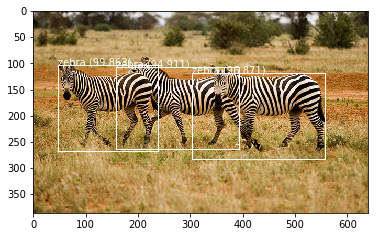

In [87]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
%matplotlib inline

 
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = int(len(anchors)/2) # this is number of anchor boxes
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5 # Shall give you 80 classes or labels
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
 
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()
    
# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = '/home/scar3crow/Downloads/zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

 
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels. See there are 80 classes in YOLO
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [81]:
print(yhat[0][0].shape[:2])
print(yhat[0][0].shape)
print(len(boxes))

(13, 13)
(13, 13, 255)
10647


In [58]:
c = yhat[0][0].reshape((13, 13, 3, -1))
c.shape
## explanation of 'c' : photo is broken down to 13 x 13 grid, there are 3 anchors, 85 = 5 + 80, where 5 is 
## (pc, bx, by, bh, bw) and 80 is the number of classes in YOLO we want to detect

(13, 13, 3, 85)

In [68]:
yhat[0][0]

array([[[ 0.43314534,  0.6884946 ,  0.32038185, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.6716564 ,  0.73100626,  0.12005188, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.6407958 ,  0.66604024,  0.34514347, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.3792274 ,  0.75103337,  0.31632668, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.4543453 ,  0.80951947,  0.18152569, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.42240575,  0.6409079 ,  0.42047167, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.4693456 ,  0.5123777 , -0.12142885, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.49993193,  0.4177688 , -0.12484802, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.5683294 ,  0.46802485,  0.2304089 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.5184448 ,  0.36937788,  0.31048775, ...,  

In [69]:
yhat[0][0][..., :2] ## taking 0 & 1 out of 255

array([[[0.43314534, 0.6884946 ],
        [0.6716564 , 0.73100626],
        [0.6407958 , 0.66604024],
        [0.43851894, 0.62090814],
        [0.5601195 , 0.5585133 ],
        [0.569802  , 0.5710325 ],
        [0.5419262 , 0.63467926],
        [0.5476683 , 0.713874  ],
        [0.45764345, 0.7324091 ],
        [0.49677056, 0.7116718 ],
        [0.3792274 , 0.75103337],
        [0.4543453 , 0.80951947],
        [0.42240575, 0.6409079 ]],

       [[0.4693456 , 0.5123777 ],
        [0.49993193, 0.4177688 ],
        [0.5683294 , 0.46802485],
        [0.43087462, 0.5672387 ],
        [0.47786203, 0.5639691 ],
        [0.5921114 , 0.5235764 ],
        [0.472376  , 0.4341088 ],
        [0.6432411 , 0.43162283],
        [0.32894406, 0.42751658],
        [0.4697707 , 0.3872185 ],
        [0.5184448 , 0.36937788],
        [0.4738956 , 0.3549001 ],
        [0.3929417 , 0.36785623]],

       [[0.35666057, 0.42781612],
        [0.5451751 , 0.39873073],
        [0.63131   , 0.43479988],
        [0

In [71]:
dd = _sigmoid(yhat[0][0][..., :2])
dd

array([[[0.6066245 , 0.66563195],
        [0.661874  , 0.67502606],
        [0.6549334 , 0.6606159 ],
        [0.6079061 , 0.6504251 ],
        [0.6364802 , 0.63610846],
        [0.63871753, 0.63900137],
        [0.6322604 , 0.65354973],
        [0.63359445, 0.6712566 ],
        [0.612455  , 0.67533374],
        [0.6217001 , 0.67077047],
        [0.59368676, 0.67940384],
        [0.61167186, 0.69200706],
        [0.6040588 , 0.6549586 ]],

       [[0.6152289 , 0.6253637 ],
        [0.6224433 , 0.6029492 ],
        [0.6383776 , 0.61491615],
        [0.6060825 , 0.6381258 ],
        [0.6172429 , 0.6373704 ],
        [0.6438495 , 0.6279836 ],
        [0.615946  , 0.60685444],
        [0.65548575, 0.6062611 ],
        [0.58150244, 0.6052805 ],
        [0.61532944, 0.59561294],
        [0.626784  , 0.5913086 ],
        [0.6163054 , 0.58780533],
        [0.59699064, 0.5909409 ]],

       [[0.5882318 , 0.60535204],
        [0.63301545, 0.59838265],
        [0.65278643, 0.60701925],
        [0

In [70]:
yhat[0][0][..., 4:].shape # i.e. from 5th to 55th. pl. note o to 4 is Pc, bx, by, bh, bw

(13, 13, 251)

In [66]:
# netout[..., :2]  = _sigmoid(netout[..., :2])
yhat[0][0][..., :2].shape
# yhat[0][0][..., :2]  = _sigmoid(yhat[0][0][..., :2])
# yhat[0][0][..., :2].shape

(13, 13, 2)

In [69]:
# create a YOLO v3 keras model :
# based on https://github.com/experiencor/keras-yolo3
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
 
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x
 
def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  425, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model_2= Model(input_image, [yolo_82, yolo_94, yolo_106])


	return model_2
 
 
# define the model
model_2 = make_yolov3_model()


In [70]:
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))

	def reset(self):
		self.offset = 0
        
# load the model weights
weight_reader = WeightReader('/home/scar3crow/Downloads/yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model_2)
# save the model to file
model_2.save('model_2.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [71]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
%matplotlib inline

 
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = int(len(anchors)/2) # this is number of anchor boxes
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5 # Shall give you 80 classes or labels
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
 
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()
    
# load yolov3 model
model = load_model('model_2.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = '/home/scar3crow/Downloads/zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model_2.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

 
# define the anchors
anchors = [[116,90, 156,198, 373,326, 10,13, 16,30], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels. See there are 80 classes in YOLO
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 425), (1, 26, 26, 255), (1, 52, 52, 255)]


/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


ValueError: cannot convert float NaN to integer

person 32.95224905014038
bicycle 32.95224905014038
car 32.95224905014038
motorbike 32.95224905014038
aeroplane 32.95224905014038
bus 32.95224905014038
train 32.95224905014038
truck 32.95224905014038
boat 32.95224905014038
traffic light 32.95224905014038
fire hydrant 32.95224905014038
stop sign 32.95224905014038
parking meter 32.95224905014038
bench 32.95224905014038
bird 32.95224905014038
cat 32.95224905014038
dog 32.95224905014038
horse 32.95224905014038
sheep 32.95224905014038
cow 32.95224905014038
elephant 32.95224905014038
bear 32.95224905014038
zebra 32.95224905014038
giraffe 32.95224905014038
backpack 32.95224905014038
umbrella 32.95224905014038
handbag 32.95224905014038
tie 32.95224905014038
suitcase 32.95224905014038
frisbee 32.95224905014038
skis 32.95224905014038
snowboard 32.95224905014038
sports ball 32.95224905014038
kite 32.95224905014038
baseball bat 32.95224905014038
baseball glove 32.95224905014038
skateboard 32.95224905014038
surfboard 32.95224905014038
tennis racket 

snowboard 32.952284812927246
sports ball 32.952284812927246
kite 32.952284812927246
baseball bat 32.952284812927246
baseball glove 32.952284812927246
skateboard 32.952284812927246
surfboard 32.952284812927246
tennis racket 32.952284812927246
bottle 32.952284812927246
wine glass 32.952284812927246
cup 32.952284812927246
fork 32.952284812927246
knife 32.952284812927246
spoon 32.952284812927246
bowl 32.952284812927246
banana 32.952284812927246
apple 32.952284812927246
sandwich 32.952284812927246
orange 32.952284812927246
broccoli 32.952284812927246
carrot 32.952284812927246
hot dog 32.952284812927246
pizza 32.952284812927246
donut 32.952284812927246
cake 32.952284812927246
chair 32.952284812927246
sofa 32.952284812927246
pottedplant 32.952284812927246
bed 32.952284812927246
diningtable 32.952284812927246
toilet 32.952284812927246
tvmonitor 32.952284812927246
laptop 32.952284812927246
mouse 32.952284812927246
remote 32.952284812927246
keyboard 32.952284812927246
cell phone 32.9522848129272

sink 32.95224905014038
refrigerator 32.95224905014038
book 32.95224905014038
clock 32.95224905014038
vase 32.95224905014038
scissors 32.95224905014038
teddy bear 32.95224905014038
hair drier 32.95224905014038
toothbrush 32.95224905014038
person 32.95224905014038
bicycle 32.95224905014038
car 32.95224905014038
motorbike 32.95224905014038
aeroplane 32.95224905014038
bus 32.95224905014038
train 32.95224905014038
truck 32.95224905014038
boat 32.95224905014038
traffic light 32.95224905014038
fire hydrant 32.95224905014038
stop sign 32.95224905014038
parking meter 32.95224905014038
bench 32.95224905014038
bird 32.95224905014038
cat 32.95224905014038
dog 32.95224905014038
horse 32.95224905014038
sheep 32.95224905014038
cow 32.95224905014038
elephant 32.95224905014038
bear 32.95224905014038
zebra 32.95224905014038
giraffe 32.95224905014038
backpack 32.95224905014038
umbrella 32.95224905014038
handbag 32.95224905014038
tie 32.95224905014038
suitcase 32.95224905014038
frisbee 32.95224905014038
s

cup 32.95224905014038
fork 32.95224905014038
knife 32.95224905014038
spoon 32.95224905014038
bowl 32.95224905014038
banana 32.95224905014038
apple 32.95224905014038
sandwich 32.95224905014038
orange 32.95224905014038
broccoli 32.95224905014038
carrot 32.95224905014038
hot dog 32.95224905014038
pizza 32.95224905014038
donut 32.95224905014038
cake 32.95224905014038
chair 32.95224905014038
sofa 32.95224905014038
pottedplant 32.95224905014038
bed 32.95224905014038
diningtable 32.95224905014038
toilet 32.95224905014038
tvmonitor 32.95224905014038
laptop 32.95224905014038
mouse 32.95224905014038
remote 32.95224905014038
keyboard 32.95224905014038
cell phone 32.95224905014038
microwave 32.95224905014038
oven 32.95224905014038
toaster 32.95224905014038
sink 32.95224905014038
refrigerator 32.95224905014038
book 32.95224905014038
clock 32.95224905014038
vase 32.95224905014038
scissors 32.95224905014038
teddy bear 32.95224905014038
hair drier 32.95224905014038
toothbrush 32.95224905014038
person 

stop sign 32.95226693153381
parking meter 32.95226693153381
bench 32.95226693153381
bird 32.95226693153381
cat 32.95226693153381
dog 32.95226693153381
horse 32.95226693153381
sheep 32.95226693153381
cow 32.95226693153381
elephant 32.95226693153381
bear 32.95226693153381
zebra 32.95226693153381
giraffe 32.95226693153381
backpack 32.95226693153381
umbrella 32.95226693153381
handbag 32.95226693153381
tie 32.95226693153381
suitcase 32.95226693153381
frisbee 32.95226693153381
skis 32.95226693153381
snowboard 32.95226693153381
sports ball 32.95226693153381
kite 32.95226693153381
baseball bat 32.95226693153381
baseball glove 32.95226693153381
skateboard 32.95226693153381
surfboard 32.95226693153381
tennis racket 32.95226693153381
bottle 32.95226693153381
wine glass 32.95226693153381
cup 32.95226693153381
fork 32.95226693153381
knife 32.95226693153381
spoon 32.95226693153381
bowl 32.95226693153381
banana 32.95226693153381
apple 32.95226693153381
sandwich 32.95226693153381
orange 32.95226693153

diningtable 32.952290773391724
toilet 32.952290773391724
tvmonitor 32.952290773391724
laptop 32.952290773391724
mouse 32.952290773391724
remote 32.952290773391724
keyboard 32.952290773391724
cell phone 32.952290773391724
microwave 32.952290773391724
oven 32.952290773391724
toaster 32.952290773391724
sink 32.952290773391724
refrigerator 32.952290773391724
book 32.952290773391724
clock 32.952290773391724
vase 32.952290773391724
scissors 32.952290773391724
teddy bear 32.952290773391724
hair drier 32.952290773391724
toothbrush 32.952290773391724
person 32.95224905014038
bicycle 32.95224905014038
car 32.95224905014038
motorbike 32.95224905014038
aeroplane 32.95224905014038
bus 32.95224905014038
train 32.95224905014038
truck 32.95224905014038
boat 32.95224905014038
traffic light 32.95224905014038
fire hydrant 32.95224905014038
stop sign 32.95224905014038
parking meter 32.95224905014038
bench 32.95224905014038
bird 32.95224905014038
cat 32.95224905014038
dog 32.95224905014038
horse 32.9522490

skis 32.95224905014038
snowboard 32.95224905014038
sports ball 32.95224905014038
kite 32.95224905014038
baseball bat 32.95224905014038
baseball glove 32.95224905014038
skateboard 32.95224905014038
surfboard 32.95224905014038
tennis racket 32.95224905014038
bottle 32.95224905014038
wine glass 32.95224905014038
cup 32.95224905014038
fork 32.95224905014038
knife 32.95224905014038
spoon 32.95224905014038
bowl 32.95224905014038
banana 32.95224905014038
apple 32.95224905014038
sandwich 32.95224905014038
orange 32.95224905014038
broccoli 32.95224905014038
carrot 32.95224905014038
hot dog 32.95224905014038
pizza 32.95224905014038
donut 32.95224905014038
cake 32.95224905014038
chair 32.95224905014038
sofa 32.95224905014038
pottedplant 32.95224905014038
bed 32.95224905014038
diningtable 32.95224905014038
toilet 32.95224905014038
tvmonitor 32.95224905014038
laptop 32.95224905014038
mouse 32.95224905014038
remote 32.95224905014038
keyboard 32.95224905014038
cell phone 32.95224905014038
microwave 3

person 32.95228183269501
bicycle 32.95228183269501
car 32.95228183269501
motorbike 32.95228183269501
aeroplane 32.95228183269501
bus 32.95228183269501
train 32.95228183269501
truck 32.95228183269501
boat 32.95228183269501
traffic light 32.95228183269501
fire hydrant 32.95228183269501
stop sign 32.95228183269501
parking meter 32.95228183269501
bench 32.95228183269501
bird 32.95228183269501
cat 32.95228183269501
dog 32.95228183269501
horse 32.95228183269501
sheep 32.95228183269501
cow 32.95228183269501
elephant 32.95228183269501
bear 32.95228183269501
zebra 32.95228183269501
giraffe 32.95228183269501
backpack 32.95228183269501
umbrella 32.95228183269501
handbag 32.95228183269501
tie 32.95228183269501
suitcase 32.95228183269501
frisbee 32.95228183269501
skis 32.95228183269501
snowboard 32.95228183269501
sports ball 32.95228183269501
kite 32.95228183269501
baseball bat 32.95228183269501
baseball glove 32.95228183269501
skateboard 32.95228183269501
surfboard 32.95228183269501
tennis racket 

broccoli 32.95226693153381
carrot 32.95226693153381
hot dog 32.95226693153381
pizza 32.95226693153381
donut 32.95226693153381
cake 32.95226693153381
chair 32.95226693153381
sofa 32.95226693153381
pottedplant 32.95226693153381
bed 32.95226693153381
diningtable 32.95226693153381
toilet 32.95226693153381
tvmonitor 32.95226693153381
laptop 32.95226693153381
mouse 32.95226693153381
remote 32.95226693153381
keyboard 32.95226693153381
cell phone 32.95226693153381
microwave 32.95226693153381
oven 32.95226693153381
toaster 32.95226693153381
sink 32.95226693153381
refrigerator 32.95226693153381
book 32.95226693153381
clock 32.95226693153381
vase 32.95226693153381
scissors 32.95226693153381
teddy bear 32.95226693153381
hair drier 32.95226693153381
toothbrush 32.95226693153381
person 32.952290773391724
bicycle 32.952290773391724
car 32.952290773391724
motorbike 32.952290773391724
aeroplane 32.952290773391724
bus 32.952290773391724
train 32.952290773391724
truck 32.952290773391724
boat 32.952290773

cow 32.95228183269501
elephant 32.95228183269501
bear 32.95228183269501
zebra 32.95228183269501
giraffe 32.95228183269501
backpack 32.95228183269501
umbrella 32.95228183269501
handbag 32.95228183269501
tie 32.95228183269501
suitcase 32.95228183269501
frisbee 32.95228183269501
skis 32.95228183269501
snowboard 32.95228183269501
sports ball 32.95228183269501
kite 32.95228183269501
baseball bat 32.95228183269501
baseball glove 32.95228183269501
skateboard 32.95228183269501
surfboard 32.95228183269501
tennis racket 32.95228183269501
bottle 32.95228183269501
wine glass 32.95228183269501
cup 32.95228183269501
fork 32.95228183269501
knife 32.95228183269501
spoon 32.95228183269501
bowl 32.95228183269501
banana 32.95228183269501
apple 32.95228183269501
sandwich 32.95228183269501
orange 32.95228183269501
broccoli 32.95228183269501
carrot 32.95228183269501
hot dog 32.95228183269501
pizza 32.95228183269501
donut 32.95228183269501
cake 32.95228183269501
chair 32.95228183269501
sofa 32.95228183269501

oven 32.95224905014038
toaster 32.95224905014038
sink 32.95224905014038
refrigerator 32.95224905014038
book 32.95224905014038
clock 32.95224905014038
vase 32.95224905014038
scissors 32.95224905014038
teddy bear 32.95224905014038
hair drier 32.95224905014038
toothbrush 32.95224905014038
person 32.95224905014038
bicycle 32.95224905014038
car 32.95224905014038
motorbike 32.95224905014038
aeroplane 32.95224905014038
bus 32.95224905014038
train 32.95224905014038
truck 32.95224905014038
boat 32.95224905014038
traffic light 32.95224905014038
fire hydrant 32.95224905014038
stop sign 32.95224905014038
parking meter 32.95224905014038
bench 32.95224905014038
bird 32.95224905014038
cat 32.95224905014038
dog 32.95224905014038
horse 32.95224905014038
sheep 32.95224905014038
cow 32.95224905014038
elephant 32.95224905014038
bear 32.95224905014038
zebra 32.95224905014038
giraffe 32.95224905014038
backpack 32.95224905014038
umbrella 32.95224905014038
handbag 32.95224905014038
tie 32.95224905014038
suitc

bottle 32.95224905014038
wine glass 32.95224905014038
cup 32.95224905014038
fork 32.95224905014038
knife 32.95224905014038
spoon 32.95224905014038
bowl 32.95224905014038
banana 32.95224905014038
apple 32.95224905014038
sandwich 32.95224905014038
orange 32.95224905014038
broccoli 32.95224905014038
carrot 32.95224905014038
hot dog 32.95224905014038
pizza 32.95224905014038
donut 32.95224905014038
cake 32.95224905014038
chair 32.95224905014038
sofa 32.95224905014038
pottedplant 32.95224905014038
bed 32.95224905014038
diningtable 32.95224905014038
toilet 32.95224905014038
tvmonitor 32.95224905014038
laptop 32.95224905014038
mouse 32.95224905014038
remote 32.95224905014038
keyboard 32.95224905014038
cell phone 32.95224905014038
microwave 32.95224905014038
oven 32.95224905014038
toaster 32.95224905014038
sink 32.95224905014038
refrigerator 32.95224905014038
book 32.95224905014038
clock 32.95224905014038
vase 32.95224905014038
scissors 32.95224905014038
teddy bear 32.95224905014038
hair drier 

traffic light 32.952287793159485
fire hydrant 32.952287793159485
stop sign 32.952287793159485
parking meter 32.952287793159485
bench 32.952287793159485
bird 32.952287793159485
cat 32.952287793159485
dog 32.952287793159485
horse 32.952287793159485
sheep 32.952287793159485
cow 32.952287793159485
elephant 32.952287793159485
bear 32.952287793159485
zebra 32.952287793159485
giraffe 32.952287793159485
backpack 32.952287793159485
umbrella 32.952287793159485
handbag 32.952287793159485
tie 32.952287793159485
suitcase 32.952287793159485
frisbee 32.952287793159485
skis 32.952287793159485
snowboard 32.952287793159485
sports ball 32.952287793159485
kite 32.952287793159485
baseball bat 32.952287793159485
baseball glove 32.952287793159485
skateboard 32.952287793159485
surfboard 32.952287793159485
tennis racket 32.952287793159485
bottle 32.952287793159485
wine glass 32.952287793159485
cup 32.952287793159485
fork 32.952287793159485
knife 32.952287793159485
spoon 32.952287793159485
bowl 32.9522877931594

pottedplant 32.952290773391724
bed 32.952290773391724
diningtable 32.952290773391724
toilet 32.952290773391724
tvmonitor 32.952290773391724
laptop 32.952290773391724
mouse 32.952290773391724
remote 32.952290773391724
keyboard 32.952290773391724
cell phone 32.952290773391724
microwave 32.952290773391724
oven 32.952290773391724
toaster 32.952290773391724
sink 32.952290773391724
refrigerator 32.952290773391724
book 32.952290773391724
clock 32.952290773391724
vase 32.952290773391724
scissors 32.952290773391724
teddy bear 32.952290773391724
hair drier 32.952290773391724
toothbrush 32.952290773391724
person 32.95227885246277
bicycle 32.95227885246277
car 32.95227885246277
motorbike 32.95227885246277
aeroplane 32.95227885246277
bus 32.95227885246277
train 32.95227885246277
truck 32.95227885246277
boat 32.95227885246277
traffic light 32.95227885246277
fire hydrant 32.95227885246277
stop sign 32.95227885246277
parking meter 32.95227885246277
bench 32.95227885246277
bird 32.95227885246277
cat 32

suitcase 32.952290773391724
frisbee 32.952290773391724
skis 32.952290773391724
snowboard 32.952290773391724
sports ball 32.952290773391724
kite 32.952290773391724
baseball bat 32.952290773391724
baseball glove 32.952290773391724
skateboard 32.952290773391724
surfboard 32.952290773391724
tennis racket 32.952290773391724
bottle 32.952290773391724
wine glass 32.952290773391724
cup 32.952290773391724
fork 32.952290773391724
knife 32.952290773391724
spoon 32.952290773391724
bowl 32.952290773391724
banana 32.952290773391724
apple 32.952290773391724
sandwich 32.952290773391724
orange 32.952290773391724
broccoli 32.952290773391724
carrot 32.952290773391724
hot dog 32.952290773391724
pizza 32.952290773391724
donut 32.952290773391724
cake 32.952290773391724
chair 32.952290773391724
sofa 32.952290773391724
pottedplant 32.952290773391724
bed 32.952290773391724
diningtable 32.952290773391724
toilet 32.952290773391724
tvmonitor 32.952290773391724
laptop 32.952290773391724
mouse 32.952290773391724
re

hair drier 32.95224905014038
toothbrush 32.95224905014038
person 32.95228183269501
bicycle 32.95228183269501
car 32.95228183269501
motorbike 32.95228183269501
aeroplane 32.95228183269501
bus 32.95228183269501
train 32.95228183269501
truck 32.95228183269501
boat 32.95228183269501
traffic light 32.95228183269501
fire hydrant 32.95228183269501
stop sign 32.95228183269501
parking meter 32.95228183269501
bench 32.95228183269501
bird 32.95228183269501
cat 32.95228183269501
dog 32.95228183269501
horse 32.95228183269501
sheep 32.95228183269501
cow 32.95228183269501
elephant 32.95228183269501
bear 32.95228183269501
zebra 32.95228183269501
giraffe 32.95228183269501
backpack 32.95228183269501
umbrella 32.95228183269501
handbag 32.95228183269501
tie 32.95228183269501
suitcase 32.95228183269501
frisbee 32.95228183269501
skis 32.95228183269501
snowboard 32.95228183269501
sports ball 32.95228183269501
kite 32.95228183269501
baseball bat 32.95228183269501
baseball glove 32.95228183269501
skateboard 32

sandwich 32.95224905014038
orange 32.95224905014038
broccoli 32.95224905014038
carrot 32.95224905014038
hot dog 32.95224905014038
pizza 32.95224905014038
donut 32.95224905014038
cake 32.95224905014038
chair 32.95224905014038
sofa 32.95224905014038
pottedplant 32.95224905014038
bed 32.95224905014038
diningtable 32.95224905014038
toilet 32.95224905014038
tvmonitor 32.95224905014038
laptop 32.95224905014038
mouse 32.95224905014038
remote 32.95224905014038
keyboard 32.95224905014038
cell phone 32.95224905014038
microwave 32.95224905014038
oven 32.95224905014038
toaster 32.95224905014038
sink 32.95224905014038
refrigerator 32.95224905014038
book 32.95224905014038
clock 32.95224905014038
vase 32.95224905014038
scissors 32.95224905014038
teddy bear 32.95224905014038
hair drier 32.95224905014038
toothbrush 32.95224905014038
person 32.952290773391724
bicycle 32.952290773391724
car 32.952290773391724
motorbike 32.952290773391724
aeroplane 32.952290773391724
bus 32.952290773391724
train 32.952290

horse 32.95224905014038
sheep 32.95224905014038
cow 32.95224905014038
elephant 32.95224905014038
bear 32.95224905014038
zebra 32.95224905014038
giraffe 32.95224905014038
backpack 32.95224905014038
umbrella 32.95224905014038
handbag 32.95224905014038
tie 32.95224905014038
suitcase 32.95224905014038
frisbee 32.95224905014038
skis 32.95224905014038
snowboard 32.95224905014038
sports ball 32.95224905014038
kite 32.95224905014038
baseball bat 32.95224905014038
baseball glove 32.95224905014038
skateboard 32.95224905014038
surfboard 32.95224905014038
tennis racket 32.95224905014038
bottle 32.95224905014038
wine glass 32.95224905014038
cup 32.95224905014038
fork 32.95224905014038
knife 32.95224905014038
spoon 32.95224905014038
bowl 32.95224905014038
banana 32.95224905014038
apple 32.95224905014038
sandwich 32.95224905014038
orange 32.95224905014038
broccoli 32.95224905014038
carrot 32.95224905014038
hot dog 32.95224905014038
pizza 32.95224905014038
donut 32.95224905014038
cake 32.9522490501403

cell phone 32.95230269432068
microwave 32.95230269432068
oven 32.95230269432068
toaster 32.95230269432068
sink 32.95230269432068
refrigerator 32.95230269432068
book 32.95230269432068
clock 32.95230269432068
vase 32.95230269432068
scissors 32.95230269432068
teddy bear 32.95230269432068
hair drier 32.95230269432068
toothbrush 32.95230269432068
person 32.95224905014038
bicycle 32.95224905014038
car 32.95224905014038
motorbike 32.95224905014038
aeroplane 32.95224905014038
bus 32.95224905014038
train 32.95224905014038
truck 32.95224905014038
boat 32.95224905014038
traffic light 32.95224905014038
fire hydrant 32.95224905014038
stop sign 32.95224905014038
parking meter 32.95224905014038
bench 32.95224905014038
bird 32.95224905014038
cat 32.95224905014038
dog 32.95224905014038
horse 32.95224905014038
sheep 32.95224905014038
cow 32.95224905014038
elephant 32.95224905014038
bear 32.95224905014038
zebra 32.95224905014038
giraffe 32.95224905014038
backpack 32.95224905014038
umbrella 32.95224905014

surfboard 32.95224905014038
tennis racket 32.95224905014038
bottle 32.95224905014038
wine glass 32.95224905014038
cup 32.95224905014038
fork 32.95224905014038
knife 32.95224905014038
spoon 32.95224905014038
bowl 32.95224905014038
banana 32.95224905014038
apple 32.95224905014038
sandwich 32.95224905014038
orange 32.95224905014038
broccoli 32.95224905014038
carrot 32.95224905014038
hot dog 32.95224905014038
pizza 32.95224905014038
donut 32.95224905014038
cake 32.95224905014038
chair 32.95224905014038
sofa 32.95224905014038
pottedplant 32.95224905014038
bed 32.95224905014038
diningtable 32.95224905014038
toilet 32.95224905014038
tvmonitor 32.95224905014038
laptop 32.95224905014038
mouse 32.95224905014038
remote 32.95224905014038
keyboard 32.95224905014038
cell phone 32.95224905014038
microwave 32.95224905014038
oven 32.95224905014038
toaster 32.95224905014038
sink 32.95224905014038
refrigerator 32.95224905014038
book 32.95224905014038
clock 32.95224905014038
vase 32.95224905014038
scissor

truck 32.95224905014038
boat 32.95224905014038
traffic light 32.95224905014038
fire hydrant 32.95224905014038
stop sign 32.95224905014038
parking meter 32.95224905014038
bench 32.95224905014038
bird 32.95224905014038
cat 32.95224905014038
dog 32.95224905014038
horse 32.95224905014038
sheep 32.95224905014038
cow 32.95224905014038
elephant 32.95224905014038
bear 32.95224905014038
zebra 32.95224905014038
giraffe 32.95224905014038
backpack 32.95224905014038
umbrella 32.95224905014038
handbag 32.95224905014038
tie 32.95224905014038
suitcase 32.95224905014038
frisbee 32.95224905014038
skis 32.95224905014038
snowboard 32.95224905014038
sports ball 32.95224905014038
kite 32.95224905014038
baseball bat 32.95224905014038
baseball glove 32.95224905014038
skateboard 32.95224905014038
surfboard 32.95224905014038
tennis racket 32.95224905014038
bottle 32.95224905014038
wine glass 32.95224905014038
cup 32.95224905014038
fork 32.95224905014038
knife 32.95224905014038
spoon 32.95224905014038
bowl 32.95

chair 32.95227587223053
sofa 32.95227587223053
pottedplant 32.95227587223053
bed 32.95227587223053
diningtable 32.95227587223053
toilet 32.95227587223053
tvmonitor 32.95227587223053
laptop 32.95227587223053
mouse 32.95227587223053
remote 32.95227587223053
keyboard 32.95227587223053
cell phone 32.95227587223053
microwave 32.95227587223053
oven 32.95227587223053
toaster 32.95227587223053
sink 32.95227587223053
refrigerator 32.95227587223053
book 32.95227587223053
clock 32.95227587223053
vase 32.95227587223053
scissors 32.95227587223053
teddy bear 32.95227587223053
hair drier 32.95227587223053
toothbrush 32.95227587223053
person 32.95230269432068
bicycle 32.95230269432068
car 32.95230269432068
motorbike 32.95230269432068
aeroplane 32.95230269432068
bus 32.95230269432068
train 32.95230269432068
truck 32.95230269432068
boat 32.95230269432068
traffic light 32.95230269432068
fire hydrant 32.95230269432068
stop sign 32.95230269432068
parking meter 32.95230269432068
bench 32.95230269432068
bird

handbag 32.95224905014038
tie 32.95224905014038
suitcase 32.95224905014038
frisbee 32.95224905014038
skis 32.95224905014038
snowboard 32.95224905014038
sports ball 32.95224905014038
kite 32.95224905014038
baseball bat 32.95224905014038
baseball glove 32.95224905014038
skateboard 32.95224905014038
surfboard 32.95224905014038
tennis racket 32.95224905014038
bottle 32.95224905014038
wine glass 32.95224905014038
cup 32.95224905014038
fork 32.95224905014038
knife 32.95224905014038
spoon 32.95224905014038
bowl 32.95224905014038
banana 32.95224905014038
apple 32.95224905014038
sandwich 32.95224905014038
orange 32.95224905014038
broccoli 32.95224905014038
carrot 32.95224905014038
hot dog 32.95224905014038
pizza 32.95224905014038
donut 32.95224905014038
cake 32.95224905014038
chair 32.95224905014038
sofa 32.95224905014038
pottedplant 32.95224905014038
bed 32.95224905014038
diningtable 32.95224905014038
toilet 32.95224905014038
tvmonitor 32.95224905014038
laptop 32.95224905014038
mouse 32.952249

scissors 32.952290773391724
teddy bear 32.952290773391724
hair drier 32.952290773391724
toothbrush 32.952290773391724
person 32.95228183269501
bicycle 32.95228183269501
car 32.95228183269501
motorbike 32.95228183269501
aeroplane 32.95228183269501
bus 32.95228183269501
train 32.95228183269501
truck 32.95228183269501
boat 32.95228183269501
traffic light 32.95228183269501
fire hydrant 32.95228183269501
stop sign 32.95228183269501
parking meter 32.95228183269501
bench 32.95228183269501
bird 32.95228183269501
cat 32.95228183269501
dog 32.95228183269501
horse 32.95228183269501
sheep 32.95228183269501
cow 32.95228183269501
elephant 32.95228183269501
bear 32.95228183269501
zebra 32.95228183269501
giraffe 32.95228183269501
backpack 32.95228183269501
umbrella 32.95228183269501
handbag 32.95228183269501
tie 32.95228183269501
suitcase 32.95228183269501
frisbee 32.95228183269501
skis 32.95228183269501
snowboard 32.95228183269501
sports ball 32.95228183269501
kite 32.95228183269501
baseball bat 32.9

banana 32.95224905014038
apple 32.95224905014038
sandwich 32.95224905014038
orange 32.95224905014038
broccoli 32.95224905014038
carrot 32.95224905014038
hot dog 32.95224905014038
pizza 32.95224905014038
donut 32.95224905014038
cake 32.95224905014038
chair 32.95224905014038
sofa 32.95224905014038
pottedplant 32.95224905014038
bed 32.95224905014038
diningtable 32.95224905014038
toilet 32.95224905014038
tvmonitor 32.95224905014038
laptop 32.95224905014038
mouse 32.95224905014038
remote 32.95224905014038
keyboard 32.95224905014038
cell phone 32.95224905014038
microwave 32.95224905014038
oven 32.95224905014038
toaster 32.95224905014038
sink 32.95224905014038
refrigerator 32.95224905014038
book 32.95224905014038
clock 32.95224905014038
vase 32.95224905014038
scissors 32.95224905014038
teddy bear 32.95224905014038
hair drier 32.95224905014038
toothbrush 32.95224905014038
person 32.95224905014038
bicycle 32.95224905014038
car 32.95224905014038
motorbike 32.95224905014038
aeroplane 32.952249050

cat 32.95229971408844
dog 32.95229971408844
horse 32.95229971408844
sheep 32.95229971408844
cow 32.95229971408844
elephant 32.95229971408844
bear 32.95229971408844
zebra 32.95229971408844
giraffe 32.95229971408844
backpack 32.95229971408844
umbrella 32.95229971408844
handbag 32.95229971408844
tie 32.95229971408844
suitcase 32.95229971408844
frisbee 32.95229971408844
skis 32.95229971408844
snowboard 32.95229971408844
sports ball 32.95229971408844
kite 32.95229971408844
baseball bat 32.95229971408844
baseball glove 32.95229971408844
skateboard 32.95229971408844
surfboard 32.95229971408844
tennis racket 32.95229971408844
bottle 32.95229971408844
wine glass 32.95229971408844
cup 32.95229971408844
fork 32.95229971408844
knife 32.95229971408844
spoon 32.95229971408844
bowl 32.95229971408844
banana 32.95229971408844
apple 32.95229971408844
sandwich 32.95229971408844
orange 32.95229971408844
broccoli 32.95229971408844
carrot 32.95229971408844
hot dog 32.95229971408844
pizza 32.95229971408844
d

kite 32.95230269432068
baseball bat 32.95230269432068
baseball glove 32.95230269432068
skateboard 32.95230269432068
surfboard 32.95230269432068
tennis racket 32.95230269432068
bottle 32.95230269432068
wine glass 32.95230269432068
cup 32.95230269432068
fork 32.95230269432068
knife 32.95230269432068
spoon 32.95230269432068
bowl 32.95230269432068
banana 32.95230269432068
apple 32.95230269432068
sandwich 32.95230269432068
orange 32.95230269432068
broccoli 32.95230269432068
carrot 32.95230269432068
hot dog 32.95230269432068
pizza 32.95230269432068
donut 32.95230269432068
cake 32.95230269432068
chair 32.95230269432068
sofa 32.95230269432068
pottedplant 32.95230269432068
bed 32.95230269432068
diningtable 32.95230269432068
toilet 32.95230269432068
tvmonitor 32.95230269432068
laptop 32.95230269432068
mouse 32.95230269432068
remote 32.95230269432068
keyboard 32.95230269432068
cell phone 32.95230269432068
microwave 32.95230269432068
oven 32.95230269432068
toaster 32.95230269432068
sink 32.9523026

bowl 32.952263951301575
banana 32.952263951301575
apple 32.952263951301575
sandwich 32.952263951301575
orange 32.952263951301575
broccoli 32.952263951301575
carrot 32.952263951301575
hot dog 32.952263951301575
pizza 32.952263951301575
donut 32.952263951301575
cake 32.952263951301575
chair 32.952263951301575
sofa 32.952263951301575
pottedplant 32.952263951301575
bed 32.952263951301575
diningtable 32.952263951301575
toilet 32.952263951301575
tvmonitor 32.952263951301575
laptop 32.952263951301575
mouse 32.952263951301575
remote 32.952263951301575
keyboard 32.952263951301575
cell phone 32.952263951301575
microwave 32.952263951301575
oven 32.952263951301575
toaster 32.952263951301575
sink 32.952263951301575
refrigerator 32.952263951301575
book 32.952263951301575
clock 32.952263951301575
vase 32.952263951301575
scissors 32.952263951301575
teddy bear 32.952263951301575
hair drier 32.952263951301575
toothbrush 32.952263951301575
person 32.95224905014038
bicycle 32.95224905014038
car 32.9522490

cat 32.95228183269501
dog 32.95228183269501
horse 32.95228183269501
sheep 32.95228183269501
cow 32.95228183269501
elephant 32.95228183269501
bear 32.95228183269501
zebra 32.95228183269501
giraffe 32.95228183269501
backpack 32.95228183269501
umbrella 32.95228183269501
handbag 32.95228183269501
tie 32.95228183269501
suitcase 32.95228183269501
frisbee 32.95228183269501
skis 32.95228183269501
snowboard 32.95228183269501
sports ball 32.95228183269501
kite 32.95228183269501
baseball bat 32.95228183269501
baseball glove 32.95228183269501
skateboard 32.95228183269501
surfboard 32.95228183269501
tennis racket 32.95228183269501
bottle 32.95228183269501
wine glass 32.95228183269501
cup 32.95228183269501
fork 32.95228183269501
knife 32.95228183269501
spoon 32.95228183269501
bowl 32.95228183269501
banana 32.95228183269501
apple 32.95228183269501
sandwich 32.95228183269501
orange 32.95228183269501
broccoli 32.95228183269501
carrot 32.95228183269501
hot dog 32.95228183269501
pizza 32.95228183269501
d

mouse 32.95228183269501
remote 32.95228183269501
keyboard 32.95228183269501
cell phone 32.95228183269501
microwave 32.95228183269501
oven 32.95228183269501
toaster 32.95228183269501
sink 32.95228183269501
refrigerator 32.95228183269501
book 32.95228183269501
clock 32.95228183269501
vase 32.95228183269501
scissors 32.95228183269501
teddy bear 32.95228183269501
hair drier 32.95228183269501
toothbrush 32.95228183269501
person 32.952284812927246
bicycle 32.952284812927246
car 32.952284812927246
motorbike 32.952284812927246
aeroplane 32.952284812927246
bus 32.952284812927246
train 32.952284812927246
truck 32.952284812927246
boat 32.952284812927246
traffic light 32.952284812927246
fire hydrant 32.952284812927246
stop sign 32.952284812927246
parking meter 32.952284812927246
bench 32.952284812927246
bird 32.952284812927246
cat 32.952284812927246
dog 32.952284812927246
horse 32.952284812927246
sheep 32.952284812927246
cow 32.952284812927246
elephant 32.952284812927246
bear 32.952284812927246
ze

person 32.95228183269501
bicycle 32.95228183269501
car 32.95228183269501
motorbike 32.95228183269501
aeroplane 32.95228183269501
bus 32.95228183269501
train 32.95228183269501
truck 32.95228183269501
boat 32.95228183269501
traffic light 32.95228183269501
fire hydrant 32.95228183269501
stop sign 32.95228183269501
parking meter 32.95228183269501
bench 32.95228183269501
bird 32.95228183269501
cat 32.95228183269501
dog 32.95228183269501
horse 32.95228183269501
sheep 32.95228183269501
cow 32.95228183269501
elephant 32.95228183269501
bear 32.95228183269501
zebra 32.95228183269501
giraffe 32.95228183269501
backpack 32.95228183269501
umbrella 32.95228183269501
handbag 32.95228183269501
tie 32.95228183269501
suitcase 32.95228183269501
frisbee 32.95228183269501
skis 32.95228183269501
snowboard 32.95228183269501
sports ball 32.95228183269501
kite 32.95228183269501
baseball bat 32.95228183269501
baseball glove 32.95228183269501
skateboard 32.95228183269501
surfboard 32.95228183269501
tennis racket 

aeroplane 32.95224905014038
bus 32.95224905014038
train 32.95224905014038
truck 32.95224905014038
boat 32.95224905014038
traffic light 32.95224905014038
fire hydrant 32.95224905014038
stop sign 32.95224905014038
parking meter 32.95224905014038
bench 32.95224905014038
bird 32.95224905014038
cat 32.95224905014038
dog 32.95224905014038
horse 32.95224905014038
sheep 32.95224905014038
cow 32.95224905014038
elephant 32.95224905014038
bear 32.95224905014038
zebra 32.95224905014038
giraffe 32.95224905014038
backpack 32.95224905014038
umbrella 32.95224905014038
handbag 32.95224905014038
tie 32.95224905014038
suitcase 32.95224905014038
frisbee 32.95224905014038
skis 32.95224905014038
snowboard 32.95224905014038
sports ball 32.95224905014038
kite 32.95224905014038
baseball bat 32.95224905014038
baseball glove 32.95224905014038
skateboard 32.95224905014038
surfboard 32.95224905014038
tennis racket 32.95224905014038
bottle 32.95224905014038
wine glass 32.95224905014038
cup 32.95224905014038
fork 32

donut 32.95226991176605
cake 32.95226991176605
chair 32.95226991176605
sofa 32.95226991176605
pottedplant 32.95226991176605
bed 32.95226991176605
diningtable 32.95226991176605
toilet 32.95226991176605
tvmonitor 32.95226991176605
laptop 32.95226991176605
mouse 32.95226991176605
remote 32.95226991176605
keyboard 32.95226991176605
cell phone 32.95226991176605
microwave 32.95226991176605
oven 32.95226991176605
toaster 32.95226991176605
sink 32.95226991176605
refrigerator 32.95226991176605
book 32.95226991176605
clock 32.95226991176605
vase 32.95226991176605
scissors 32.95226991176605
teddy bear 32.95226991176605
hair drier 32.95226991176605
toothbrush 32.95226991176605
person 32.95224905014038
bicycle 32.95224905014038
car 32.95224905014038
motorbike 32.95224905014038
aeroplane 32.95224905014038
bus 32.95224905014038
train 32.95224905014038
truck 32.95224905014038
boat 32.95224905014038
traffic light 32.95224905014038
fire hydrant 32.95224905014038
stop sign 32.95224905014038
parking meter

giraffe 32.95226991176605
backpack 32.95226991176605
umbrella 32.95226991176605
handbag 32.95226991176605
tie 32.95226991176605
suitcase 32.95226991176605
frisbee 32.95226991176605
skis 32.95226991176605
snowboard 32.95226991176605
sports ball 32.95226991176605
kite 32.95226991176605
baseball bat 32.95226991176605
baseball glove 32.95226991176605
skateboard 32.95226991176605
surfboard 32.95226991176605
tennis racket 32.95226991176605
bottle 32.95226991176605
wine glass 32.95226991176605
cup 32.95226991176605
fork 32.95226991176605
knife 32.95226991176605
spoon 32.95226991176605
bowl 32.95226991176605
banana 32.95226991176605
apple 32.95226991176605
sandwich 32.95226991176605
orange 32.95226991176605
broccoli 32.95226991176605
carrot 32.95226991176605
hot dog 32.95226991176605
pizza 32.95226991176605
donut 32.95226991176605
cake 32.95226991176605
chair 32.95226991176605
sofa 32.95226991176605
pottedplant 32.95226991176605
bed 32.95226991176605
diningtable 32.95226991176605
toilet 32.952

book 32.95224905014038
clock 32.95224905014038
vase 32.95224905014038
scissors 32.95224905014038
teddy bear 32.95224905014038
hair drier 32.95224905014038
toothbrush 32.95224905014038
person 32.95227587223053
bicycle 32.95227587223053
car 32.95227587223053
motorbike 32.95227587223053
aeroplane 32.95227587223053
bus 32.95227587223053
train 32.95227587223053
truck 32.95227587223053
boat 32.95227587223053
traffic light 32.95227587223053
fire hydrant 32.95227587223053
stop sign 32.95227587223053
parking meter 32.95227587223053
bench 32.95227587223053
bird 32.95227587223053
cat 32.95227587223053
dog 32.95227587223053
horse 32.95227587223053
sheep 32.95227587223053
cow 32.95227587223053
elephant 32.95227587223053
bear 32.95227587223053
zebra 32.95227587223053
giraffe 32.95227587223053
backpack 32.95227587223053
umbrella 32.95227587223053
handbag 32.95227587223053
tie 32.95227587223053
suitcase 32.95227587223053
frisbee 32.95227587223053
skis 32.95227587223053
snowboard 32.95227587223053
spor

knife 32.95225501060486
spoon 32.95225501060486
bowl 32.95225501060486
banana 32.95225501060486
apple 32.95225501060486
sandwich 32.95225501060486
orange 32.95225501060486
broccoli 32.95225501060486
carrot 32.95225501060486
hot dog 32.95225501060486
pizza 32.95225501060486
donut 32.95225501060486
cake 32.95225501060486
chair 32.95225501060486
sofa 32.95225501060486
pottedplant 32.95225501060486
bed 32.95225501060486
diningtable 32.95225501060486
toilet 32.95225501060486
tvmonitor 32.95225501060486
laptop 32.95225501060486
mouse 32.95225501060486
remote 32.95225501060486
keyboard 32.95225501060486
cell phone 32.95225501060486
microwave 32.95225501060486
oven 32.95225501060486
toaster 32.95225501060486
sink 32.95225501060486
refrigerator 32.95225501060486
book 32.95225501060486
clock 32.95225501060486
vase 32.95225501060486
scissors 32.95225501060486
teddy bear 32.95225501060486
hair drier 32.95225501060486
toothbrush 32.95225501060486
person 32.95224905014038
bicycle 32.95224905014038
c

bench 32.95226693153381
bird 32.95226693153381
cat 32.95226693153381
dog 32.95226693153381
horse 32.95226693153381
sheep 32.95226693153381
cow 32.95226693153381
elephant 32.95226693153381
bear 32.95226693153381
zebra 32.95226693153381
giraffe 32.95226693153381
backpack 32.95226693153381
umbrella 32.95226693153381
handbag 32.95226693153381
tie 32.95226693153381
suitcase 32.95226693153381
frisbee 32.95226693153381
skis 32.95226693153381
snowboard 32.95226693153381
sports ball 32.95226693153381
kite 32.95226693153381
baseball bat 32.95226693153381
baseball glove 32.95226693153381
skateboard 32.95226693153381
surfboard 32.95226693153381
tennis racket 32.95226693153381
bottle 32.95226693153381
wine glass 32.95226693153381
cup 32.95226693153381
fork 32.95226693153381
knife 32.95226693153381
spoon 32.95226693153381
bowl 32.95226693153381
banana 32.95226693153381
apple 32.95226693153381
sandwich 32.95226693153381
orange 32.95226693153381
broccoli 32.95226693153381
carrot 32.95226693153381
hot 

tvmonitor 32.95224905014038
laptop 32.95224905014038
mouse 32.95224905014038
remote 32.95224905014038
keyboard 32.95224905014038
cell phone 32.95224905014038
microwave 32.95224905014038
oven 32.95224905014038
toaster 32.95224905014038
sink 32.95224905014038
refrigerator 32.95224905014038
book 32.95224905014038
clock 32.95224905014038
vase 32.95224905014038
scissors 32.95224905014038
teddy bear 32.95224905014038
hair drier 32.95224905014038
toothbrush 32.95224905014038
person 32.95224905014038
bicycle 32.95224905014038
car 32.95224905014038
motorbike 32.95224905014038
aeroplane 32.95224905014038
bus 32.95224905014038
train 32.95224905014038
truck 32.95224905014038
boat 32.95224905014038
traffic light 32.95224905014038
fire hydrant 32.95224905014038
stop sign 32.95224905014038
parking meter 32.95224905014038
bench 32.95224905014038
bird 32.95224905014038
cat 32.95224905014038
dog 32.95224905014038
horse 32.95224905014038
sheep 32.95224905014038
cow 32.95224905014038
elephant 32.952249050

sports ball 32.95224905014038
kite 32.95224905014038
baseball bat 32.95224905014038
baseball glove 32.95224905014038
skateboard 32.95224905014038
surfboard 32.95224905014038
tennis racket 32.95224905014038
bottle 32.95224905014038
wine glass 32.95224905014038
cup 32.95224905014038
fork 32.95224905014038
knife 32.95224905014038
spoon 32.95224905014038
bowl 32.95224905014038
banana 32.95224905014038
apple 32.95224905014038
sandwich 32.95224905014038
orange 32.95224905014038
broccoli 32.95224905014038
carrot 32.95224905014038
hot dog 32.95224905014038
pizza 32.95224905014038
donut 32.95224905014038
cake 32.95224905014038
chair 32.95224905014038
sofa 32.95224905014038
pottedplant 32.95224905014038
bed 32.95224905014038
diningtable 32.95224905014038
toilet 32.95224905014038
tvmonitor 32.95224905014038
laptop 32.95224905014038
mouse 32.95224905014038
remote 32.95224905014038
keyboard 32.95224905014038
cell phone 32.95224905014038
microwave 32.95224905014038
oven 32.95224905014038
toaster 32.

car 32.95224905014038
motorbike 32.95224905014038
aeroplane 32.95224905014038
bus 32.95224905014038
train 32.95224905014038
truck 32.95224905014038
boat 32.95224905014038
traffic light 32.95224905014038
fire hydrant 32.95224905014038
stop sign 32.95224905014038
parking meter 32.95224905014038
bench 32.95224905014038
bird 32.95224905014038
cat 32.95224905014038
dog 32.95224905014038
horse 32.95224905014038
sheep 32.95224905014038
cow 32.95224905014038
elephant 32.95224905014038
bear 32.95224905014038
zebra 32.95224905014038
giraffe 32.95224905014038
backpack 32.95224905014038
umbrella 32.95224905014038
handbag 32.95224905014038
tie 32.95224905014038
suitcase 32.95224905014038
frisbee 32.95224905014038
skis 32.95224905014038
snowboard 32.95224905014038
sports ball 32.95224905014038
kite 32.95224905014038
baseball bat 32.95224905014038
baseball glove 32.95224905014038
skateboard 32.95224905014038
surfboard 32.95224905014038
tennis racket 32.95224905014038
bottle 32.95224905014038
wine gla

hot dog 32.95224905014038
pizza 32.95224905014038
donut 32.95224905014038
cake 32.95224905014038
chair 32.95224905014038
sofa 32.95224905014038
pottedplant 32.95224905014038
bed 32.95224905014038
diningtable 32.95224905014038
toilet 32.95224905014038
tvmonitor 32.95224905014038
laptop 32.95224905014038
mouse 32.95224905014038
remote 32.95224905014038
keyboard 32.95224905014038
cell phone 32.95224905014038
microwave 32.95224905014038
oven 32.95224905014038
toaster 32.95224905014038
sink 32.95224905014038
refrigerator 32.95224905014038
book 32.95224905014038
clock 32.95224905014038
vase 32.95224905014038
scissors 32.95224905014038
teddy bear 32.95224905014038
hair drier 32.95224905014038
toothbrush 32.95224905014038
person 32.95224905014038
bicycle 32.95224905014038
car 32.95224905014038
motorbike 32.95224905014038
aeroplane 32.95224905014038
bus 32.95224905014038
train 32.95224905014038
truck 32.95224905014038
boat 32.95224905014038
traffic light 32.95224905014038
fire hydrant 32.952249

bear 32.95227289199829
zebra 32.95227289199829
giraffe 32.95227289199829
backpack 32.95227289199829
umbrella 32.95227289199829
handbag 32.95227289199829
tie 32.95227289199829
suitcase 32.95227289199829
frisbee 32.95227289199829
skis 32.95227289199829
snowboard 32.95227289199829
sports ball 32.95227289199829
kite 32.95227289199829
baseball bat 32.95227289199829
baseball glove 32.95227289199829
skateboard 32.95227289199829
surfboard 32.95227289199829
tennis racket 32.95227289199829
bottle 32.95227289199829
wine glass 32.95227289199829
cup 32.95227289199829
fork 32.95227289199829
knife 32.95227289199829
spoon 32.95227289199829
bowl 32.95227289199829
banana 32.95227289199829
apple 32.95227289199829
sandwich 32.95227289199829
orange 32.95227289199829
broccoli 32.95227289199829
carrot 32.95227289199829
hot dog 32.95227289199829
pizza 32.95227289199829
donut 32.95227289199829
cake 32.95227289199829
chair 32.95227289199829
sofa 32.95227289199829
pottedplant 32.95227289199829
bed 32.95227289199

bicycle 32.95228183269501
car 32.95228183269501
motorbike 32.95228183269501
aeroplane 32.95228183269501
bus 32.95228183269501
train 32.95228183269501
truck 32.95228183269501
boat 32.95228183269501
traffic light 32.95228183269501
fire hydrant 32.95228183269501
stop sign 32.95228183269501
parking meter 32.95228183269501
bench 32.95228183269501
bird 32.95228183269501
cat 32.95228183269501
dog 32.95228183269501
horse 32.95228183269501
sheep 32.95228183269501
cow 32.95228183269501
elephant 32.95228183269501
bear 32.95228183269501
zebra 32.95228183269501
giraffe 32.95228183269501
backpack 32.95228183269501
umbrella 32.95228183269501
handbag 32.95228183269501
tie 32.95228183269501
suitcase 32.95228183269501
frisbee 32.95228183269501
skis 32.95228183269501
snowboard 32.95228183269501
sports ball 32.95228183269501
kite 32.95228183269501
baseball bat 32.95228183269501
baseball glove 32.95228183269501
skateboard 32.95228183269501
surfboard 32.95228183269501
tennis racket 32.95228183269501
bottle 

carrot 32.952284812927246
hot dog 32.952284812927246
pizza 32.952284812927246
donut 32.952284812927246
cake 32.952284812927246
chair 32.952284812927246
sofa 32.952284812927246
pottedplant 32.952284812927246
bed 32.952284812927246
diningtable 32.952284812927246
toilet 32.952284812927246
tvmonitor 32.952284812927246
laptop 32.952284812927246
mouse 32.952284812927246
remote 32.952284812927246
keyboard 32.952284812927246
cell phone 32.952284812927246
microwave 32.952284812927246
oven 32.952284812927246
toaster 32.952284812927246
sink 32.952284812927246
refrigerator 32.952284812927246
book 32.952284812927246
clock 32.952284812927246
vase 32.952284812927246
scissors 32.952284812927246
teddy bear 32.952284812927246
hair drier 32.952284812927246
toothbrush 32.952284812927246
person 32.95224905014038
bicycle 32.95224905014038
car 32.95224905014038
motorbike 32.95224905014038
aeroplane 32.95224905014038
bus 32.95224905014038
train 32.95224905014038
truck 32.95224905014038
boat 32.95224905014038


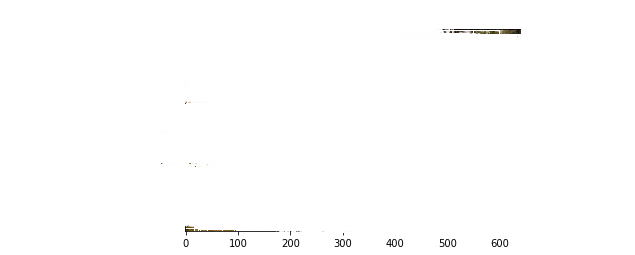

In [82]:
# define the anchors
anchors = [[116,90, 156,198, 373,326, 10,13, 16,30], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.32
boxes = list()
for i in range(len(yhat)-2):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels. See there are 80 classes in YOLO
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [74]:
len(v_boxes)

0

In [72]:
yhat[1][0][0][0][0]

nan

In [36]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        print(x_offset, x_scale)
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        print(y_offset, y_scale)
#        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
#        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
#        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
#        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        print('===================================', i)


In [37]:
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

0.0 1.0
0.0 1.0
=================================== 0
0.0 1.0
0.0 1.0
=================================== 1
0.0 1.0
0.0 1.0
=================================== 2
0.0 1.0
0.0 1.0
=================================== 3
0.0 1.0
0.0 1.0
=================================== 4
0.0 1.0
0.0 1.0
=================================== 5
0.0 1.0
0.0 1.0
=================================== 6
0.0 1.0
0.0 1.0
=================================== 7
0.0 1.0
0.0 1.0
=================================== 8
0.0 1.0
0.0 1.0
=================================== 9
0.0 1.0
0.0 1.0
=================================== 10
0.0 1.0
0.0 1.0
=================================== 11
0.0 1.0
0.0 1.0
=================================== 12
0.0 1.0
0.0 1.0
=================================== 13
0.0 1.0
0.0 1.0
=================================== 14
0.0 1.0
0.0 1.0
=================================== 15
0.0 1.0
0.0 1.0
=================================== 16
0.0 1.0
0.0 1.0
=================================== 17
0.0 1.0
0.0 1.0
====

0.0 1.0
=================================== 365
0.0 1.0
0.0 1.0
=================================== 366
0.0 1.0
0.0 1.0
=================================== 367
0.0 1.0
0.0 1.0
=================================== 368
0.0 1.0
0.0 1.0
=================================== 369
0.0 1.0
0.0 1.0
=================================== 370
0.0 1.0
0.0 1.0
=================================== 371
0.0 1.0
0.0 1.0
=================================== 372
0.0 1.0
0.0 1.0
=================================== 373
0.0 1.0
0.0 1.0
=================================== 374
0.0 1.0
0.0 1.0
=================================== 375
0.0 1.0
0.0 1.0
=================================== 376
0.0 1.0
0.0 1.0
=================================== 377
0.0 1.0
0.0 1.0
=================================== 378
0.0 1.0
0.0 1.0
=================================== 379
0.0 1.0
0.0 1.0
=================================== 380
0.0 1.0
0.0 1.0
=================================== 381
0.0 1.0
0.0 1.0
=================================== 382


=================================== 781
0.0 1.0
0.0 1.0
=================================== 782
0.0 1.0
0.0 1.0
=================================== 783
0.0 1.0
0.0 1.0
=================================== 784
0.0 1.0
0.0 1.0
=================================== 785
0.0 1.0
0.0 1.0
=================================== 786
0.0 1.0
0.0 1.0
=================================== 787
0.0 1.0
0.0 1.0
=================================== 788
0.0 1.0
0.0 1.0
=================================== 789
0.0 1.0
0.0 1.0
=================================== 790
0.0 1.0
0.0 1.0
=================================== 791
0.0 1.0
0.0 1.0
=================================== 792
0.0 1.0
0.0 1.0
=================================== 793
0.0 1.0
0.0 1.0
=================================== 794
0.0 1.0
0.0 1.0
=================================== 795
0.0 1.0
0.0 1.0
=================================== 796
0.0 1.0
0.0 1.0
=================================== 797
0.0 1.0
0.0 1.0
=================================== 798
0.0 1.0


0.0 1.0
=================================== 1198
0.0 1.0
0.0 1.0
=================================== 1199
0.0 1.0
0.0 1.0
=================================== 1200
0.0 1.0
0.0 1.0
=================================== 1201
0.0 1.0
0.0 1.0
=================================== 1202
0.0 1.0
0.0 1.0
=================================== 1203
0.0 1.0
0.0 1.0
=================================== 1204
0.0 1.0
0.0 1.0
=================================== 1205
0.0 1.0
0.0 1.0
=================================== 1206
0.0 1.0
0.0 1.0
=================================== 1207
0.0 1.0
0.0 1.0
=================================== 1208
0.0 1.0
0.0 1.0
=================================== 1209
0.0 1.0
0.0 1.0
=================================== 1210
0.0 1.0
0.0 1.0
=================================== 1211
0.0 1.0
0.0 1.0
=================================== 1212
0.0 1.0
0.0 1.0
=================================== 1213
0.0 1.0
0.0 1.0
=================================== 1214
0.0 1.0
0.0 1.0
=======================

0.0 1.0
0.0 1.0
=================================== 1615
0.0 1.0
0.0 1.0
=================================== 1616
0.0 1.0
0.0 1.0
=================================== 1617
0.0 1.0
0.0 1.0
=================================== 1618
0.0 1.0
0.0 1.0
=================================== 1619
0.0 1.0
0.0 1.0
=================================== 1620
0.0 1.0
0.0 1.0
=================================== 1621
0.0 1.0
0.0 1.0
=================================== 1622
0.0 1.0
0.0 1.0
=================================== 1623
0.0 1.0
0.0 1.0
=================================== 1624
0.0 1.0
0.0 1.0
=================================== 1625
0.0 1.0
0.0 1.0
=================================== 1626
0.0 1.0
0.0 1.0
=================================== 1627
0.0 1.0
0.0 1.0
=================================== 1628
0.0 1.0
0.0 1.0
=================================== 1629
0.0 1.0
0.0 1.0
=================================== 1630
0.0 1.0
0.0 1.0
=================================== 1631
0.0 1.0
0.0 1.0
===============

=================================== 2031
0.0 1.0
0.0 1.0
=================================== 2032
0.0 1.0
0.0 1.0
=================================== 2033
0.0 1.0
0.0 1.0
=================================== 2034
0.0 1.0
0.0 1.0
=================================== 2035
0.0 1.0
0.0 1.0
=================================== 2036
0.0 1.0
0.0 1.0
=================================== 2037
0.0 1.0
0.0 1.0
=================================== 2038
0.0 1.0
0.0 1.0
=================================== 2039
0.0 1.0
0.0 1.0
=================================== 2040
0.0 1.0
0.0 1.0
=================================== 2041
0.0 1.0
0.0 1.0
=================================== 2042
0.0 1.0
0.0 1.0
=================================== 2043
0.0 1.0
0.0 1.0
=================================== 2044
0.0 1.0
0.0 1.0
=================================== 2045
0.0 1.0
0.0 1.0
=================================== 2046
0.0 1.0
0.0 1.0
=================================== 2047
0.0 1.0
0.0 1.0
===============================

0.0 1.0
0.0 1.0
=================================== 2448
0.0 1.0
0.0 1.0
=================================== 2449
0.0 1.0
0.0 1.0
=================================== 2450
0.0 1.0
0.0 1.0
=================================== 2451
0.0 1.0
0.0 1.0
=================================== 2452
0.0 1.0
0.0 1.0
=================================== 2453
0.0 1.0
0.0 1.0
=================================== 2454
0.0 1.0
0.0 1.0
=================================== 2455
0.0 1.0
0.0 1.0
=================================== 2456
0.0 1.0
0.0 1.0
=================================== 2457
0.0 1.0
0.0 1.0
=================================== 2458
0.0 1.0
0.0 1.0
=================================== 2459
0.0 1.0
0.0 1.0
=================================== 2460
0.0 1.0
0.0 1.0
=================================== 2461
0.0 1.0
0.0 1.0
=================================== 2462
0.0 1.0
0.0 1.0
=================================== 2463
0.0 1.0
0.0 1.0
=================================== 2464
0.0 1.0
0.0 1.0
===============

=================================== 2864
0.0 1.0
0.0 1.0
=================================== 2865
0.0 1.0
0.0 1.0
=================================== 2866
0.0 1.0
0.0 1.0
=================================== 2867
0.0 1.0
0.0 1.0
=================================== 2868
0.0 1.0
0.0 1.0
=================================== 2869
0.0 1.0
0.0 1.0
=================================== 2870
0.0 1.0
0.0 1.0
=================================== 2871
0.0 1.0
0.0 1.0
=================================== 2872
0.0 1.0
0.0 1.0
=================================== 2873
0.0 1.0
0.0 1.0
=================================== 2874
0.0 1.0
0.0 1.0
=================================== 2875
0.0 1.0
0.0 1.0
=================================== 2876
0.0 1.0
0.0 1.0
=================================== 2877
0.0 1.0
0.0 1.0
=================================== 2878
0.0 1.0
0.0 1.0
=================================== 2879
0.0 1.0
0.0 1.0
=================================== 2880
0.0 1.0
0.0 1.0
===============================

0.0 1.0
=================================== 3281
0.0 1.0
0.0 1.0
=================================== 3282
0.0 1.0
0.0 1.0
=================================== 3283
0.0 1.0
0.0 1.0
=================================== 3284
0.0 1.0
0.0 1.0
=================================== 3285
0.0 1.0
0.0 1.0
=================================== 3286
0.0 1.0
0.0 1.0
=================================== 3287
0.0 1.0
0.0 1.0
=================================== 3288
0.0 1.0
0.0 1.0
=================================== 3289
0.0 1.0
0.0 1.0
=================================== 3290
0.0 1.0
0.0 1.0
=================================== 3291
0.0 1.0
0.0 1.0
=================================== 3292
0.0 1.0
0.0 1.0
=================================== 3293
0.0 1.0
0.0 1.0
=================================== 3294
0.0 1.0
0.0 1.0
=================================== 3295
0.0 1.0
0.0 1.0
=================================== 3296
0.0 1.0
0.0 1.0
=================================== 3297
0.0 1.0
0.0 1.0
=======================

0.0 1.0
0.0 1.0
=================================== 3698
0.0 1.0
0.0 1.0
=================================== 3699
0.0 1.0
0.0 1.0
=================================== 3700
0.0 1.0
0.0 1.0
=================================== 3701
0.0 1.0
0.0 1.0
=================================== 3702
0.0 1.0
0.0 1.0
=================================== 3703
0.0 1.0
0.0 1.0
=================================== 3704
0.0 1.0
0.0 1.0
=================================== 3705
0.0 1.0
0.0 1.0
=================================== 3706
0.0 1.0
0.0 1.0
=================================== 3707
0.0 1.0
0.0 1.0
=================================== 3708
0.0 1.0
0.0 1.0
=================================== 3709
0.0 1.0
0.0 1.0
=================================== 3710
0.0 1.0
0.0 1.0
=================================== 3711
0.0 1.0
0.0 1.0
=================================== 3712
0.0 1.0
0.0 1.0
=================================== 3713
0.0 1.0
0.0 1.0
=================================== 3714
0.0 1.0
0.0 1.0
===============

0.0 1.0
=================================== 4114
0.0 1.0
0.0 1.0
=================================== 4115
0.0 1.0
0.0 1.0
=================================== 4116
0.0 1.0
0.0 1.0
=================================== 4117
0.0 1.0
0.0 1.0
=================================== 4118
0.0 1.0
0.0 1.0
=================================== 4119
0.0 1.0
0.0 1.0
=================================== 4120
0.0 1.0
0.0 1.0
=================================== 4121
0.0 1.0
0.0 1.0
=================================== 4122
0.0 1.0
0.0 1.0
=================================== 4123
0.0 1.0
0.0 1.0
=================================== 4124
0.0 1.0
0.0 1.0
=================================== 4125
0.0 1.0
0.0 1.0
=================================== 4126
0.0 1.0
0.0 1.0
=================================== 4127
0.0 1.0
0.0 1.0
=================================== 4128
0.0 1.0
0.0 1.0
=================================== 4129
0.0 1.0
0.0 1.0
=================================== 4130
0.0 1.0
0.0 1.0
=======================

0.0 1.0
0.0 1.0
=================================== 4531
0.0 1.0
0.0 1.0
=================================== 4532
0.0 1.0
0.0 1.0
=================================== 4533
0.0 1.0
0.0 1.0
=================================== 4534
0.0 1.0
0.0 1.0
=================================== 4535
0.0 1.0
0.0 1.0
=================================== 4536
0.0 1.0
0.0 1.0
=================================== 4537
0.0 1.0
0.0 1.0
=================================== 4538
0.0 1.0
0.0 1.0
=================================== 4539
0.0 1.0
0.0 1.0
=================================== 4540
0.0 1.0
0.0 1.0
=================================== 4541
0.0 1.0
0.0 1.0
=================================== 4542
0.0 1.0
0.0 1.0
=================================== 4543
0.0 1.0
0.0 1.0
=================================== 4544
0.0 1.0
0.0 1.0
=================================== 4545
0.0 1.0
0.0 1.0
=================================== 4546
0.0 1.0
0.0 1.0
=================================== 4547
0.0 1.0
0.0 1.0
===============

=================================== 4947
0.0 1.0
0.0 1.0
=================================== 4948
0.0 1.0
0.0 1.0
=================================== 4949
0.0 1.0
0.0 1.0
=================================== 4950
0.0 1.0
0.0 1.0
=================================== 4951
0.0 1.0
0.0 1.0
=================================== 4952
0.0 1.0
0.0 1.0
=================================== 4953
0.0 1.0
0.0 1.0
=================================== 4954
0.0 1.0
0.0 1.0
=================================== 4955
0.0 1.0
0.0 1.0
=================================== 4956
0.0 1.0
0.0 1.0
=================================== 4957
0.0 1.0
0.0 1.0
=================================== 4958
0.0 1.0
0.0 1.0
=================================== 4959
0.0 1.0
0.0 1.0
=================================== 4960
0.0 1.0
0.0 1.0
=================================== 4961
0.0 1.0
0.0 1.0
=================================== 4962
0.0 1.0
0.0 1.0
=================================== 4963
0.0 1.0
0.0 1.0
===============================

0.0 1.0
=================================== 5364
0.0 1.0
0.0 1.0
=================================== 5365
0.0 1.0
0.0 1.0
=================================== 5366
0.0 1.0
0.0 1.0
=================================== 5367
0.0 1.0
0.0 1.0
=================================== 5368
0.0 1.0
0.0 1.0
=================================== 5369
0.0 1.0
0.0 1.0
=================================== 5370
0.0 1.0
0.0 1.0
=================================== 5371
0.0 1.0
0.0 1.0
=================================== 5372
0.0 1.0
0.0 1.0
=================================== 5373
0.0 1.0
0.0 1.0
=================================== 5374
0.0 1.0
0.0 1.0
=================================== 5375
0.0 1.0
0.0 1.0
=================================== 5376
0.0 1.0
0.0 1.0
=================================== 5377
0.0 1.0
0.0 1.0
=================================== 5378
0.0 1.0
0.0 1.0
=================================== 5379
0.0 1.0
0.0 1.0
=================================== 5380
0.0 1.0
0.0 1.0
=======================

=================================== 5780
0.0 1.0
0.0 1.0
=================================== 5781
0.0 1.0
0.0 1.0
=================================== 5782
0.0 1.0
0.0 1.0
=================================== 5783
0.0 1.0
0.0 1.0
=================================== 5784
0.0 1.0
0.0 1.0
=================================== 5785
0.0 1.0
0.0 1.0
=================================== 5786
0.0 1.0
0.0 1.0
=================================== 5787
0.0 1.0
0.0 1.0
=================================== 5788
0.0 1.0
0.0 1.0
=================================== 5789
0.0 1.0
0.0 1.0
=================================== 5790
0.0 1.0
0.0 1.0
=================================== 5791
0.0 1.0
0.0 1.0
=================================== 5792
0.0 1.0
0.0 1.0
=================================== 5793
0.0 1.0
0.0 1.0
=================================== 5794
0.0 1.0
0.0 1.0
=================================== 5795
0.0 1.0
0.0 1.0
=================================== 5796
0.0 1.0
0.0 1.0
===============================

0.0 1.0
=================================== 6197
0.0 1.0
0.0 1.0
=================================== 6198
0.0 1.0
0.0 1.0
=================================== 6199
0.0 1.0
0.0 1.0
=================================== 6200
0.0 1.0
0.0 1.0
=================================== 6201
0.0 1.0
0.0 1.0
=================================== 6202
0.0 1.0
0.0 1.0
=================================== 6203
0.0 1.0
0.0 1.0
=================================== 6204
0.0 1.0
0.0 1.0
=================================== 6205
0.0 1.0
0.0 1.0
=================================== 6206
0.0 1.0
0.0 1.0
=================================== 6207
0.0 1.0
0.0 1.0
=================================== 6208
0.0 1.0
0.0 1.0
=================================== 6209
0.0 1.0
0.0 1.0
=================================== 6210
0.0 1.0
0.0 1.0
=================================== 6211
0.0 1.0
0.0 1.0
=================================== 6212
0.0 1.0
0.0 1.0
=================================== 6213
0.0 1.0
0.0 1.0
=======================

0.0 1.0
0.0 1.0
=================================== 6614
0.0 1.0
0.0 1.0
=================================== 6615
0.0 1.0
0.0 1.0
=================================== 6616
0.0 1.0
0.0 1.0
=================================== 6617
0.0 1.0
0.0 1.0
=================================== 6618
0.0 1.0
0.0 1.0
=================================== 6619
0.0 1.0
0.0 1.0
=================================== 6620
0.0 1.0
0.0 1.0
=================================== 6621
0.0 1.0
0.0 1.0
=================================== 6622
0.0 1.0
0.0 1.0
=================================== 6623
0.0 1.0
0.0 1.0
=================================== 6624
0.0 1.0
0.0 1.0
=================================== 6625
0.0 1.0
0.0 1.0
=================================== 6626
0.0 1.0
0.0 1.0
=================================== 6627
0.0 1.0
0.0 1.0
=================================== 6628
0.0 1.0
0.0 1.0
=================================== 6629
0.0 1.0
0.0 1.0
=================================== 6630
0.0 1.0
0.0 1.0
===============

=================================== 7030
0.0 1.0
0.0 1.0
=================================== 7031
0.0 1.0
0.0 1.0
=================================== 7032
0.0 1.0
0.0 1.0
=================================== 7033
0.0 1.0
0.0 1.0
=================================== 7034
0.0 1.0
0.0 1.0
=================================== 7035
0.0 1.0
0.0 1.0
=================================== 7036
0.0 1.0
0.0 1.0
=================================== 7037
0.0 1.0
0.0 1.0
=================================== 7038
0.0 1.0
0.0 1.0
=================================== 7039
0.0 1.0
0.0 1.0
=================================== 7040
0.0 1.0
0.0 1.0
=================================== 7041
0.0 1.0
0.0 1.0
=================================== 7042
0.0 1.0
0.0 1.0
=================================== 7043
0.0 1.0
0.0 1.0
=================================== 7044
0.0 1.0
0.0 1.0
=================================== 7045
0.0 1.0
0.0 1.0
=================================== 7046
0.0 1.0
0.0 1.0
===============================

0.0 1.0
0.0 1.0
=================================== 7447
0.0 1.0
0.0 1.0
=================================== 7448
0.0 1.0
0.0 1.0
=================================== 7449
0.0 1.0
0.0 1.0
=================================== 7450
0.0 1.0
0.0 1.0
=================================== 7451
0.0 1.0
0.0 1.0
=================================== 7452
0.0 1.0
0.0 1.0
=================================== 7453
0.0 1.0
0.0 1.0
=================================== 7454
0.0 1.0
0.0 1.0
=================================== 7455
0.0 1.0
0.0 1.0
=================================== 7456
0.0 1.0
0.0 1.0
=================================== 7457
0.0 1.0
0.0 1.0
=================================== 7458
0.0 1.0
0.0 1.0
=================================== 7459
0.0 1.0
0.0 1.0
=================================== 7460
0.0 1.0
0.0 1.0
=================================== 7461
0.0 1.0
0.0 1.0
=================================== 7462
0.0 1.0
0.0 1.0
=================================== 7463
0.0 1.0
0.0 1.0
===============

=================================== 7863
0.0 1.0
0.0 1.0
=================================== 7864
0.0 1.0
0.0 1.0
=================================== 7865
0.0 1.0
0.0 1.0
=================================== 7866
0.0 1.0
0.0 1.0
=================================== 7867
0.0 1.0
0.0 1.0
=================================== 7868
0.0 1.0
0.0 1.0
=================================== 7869
0.0 1.0
0.0 1.0
=================================== 7870
0.0 1.0
0.0 1.0
=================================== 7871
0.0 1.0
0.0 1.0
=================================== 7872
0.0 1.0
0.0 1.0
=================================== 7873
0.0 1.0
0.0 1.0
=================================== 7874
0.0 1.0
0.0 1.0
=================================== 7875
0.0 1.0
0.0 1.0
=================================== 7876
0.0 1.0
0.0 1.0
=================================== 7877
0.0 1.0
0.0 1.0
=================================== 7878
0.0 1.0
0.0 1.0
=================================== 7879
0.0 1.0
0.0 1.0
===============================

0.0 1.0
=================================== 8280
0.0 1.0
0.0 1.0
=================================== 8281
0.0 1.0
0.0 1.0
=================================== 8282
0.0 1.0
0.0 1.0
=================================== 8283
0.0 1.0
0.0 1.0
=================================== 8284
0.0 1.0
0.0 1.0
=================================== 8285
0.0 1.0
0.0 1.0
=================================== 8286
0.0 1.0
0.0 1.0
=================================== 8287
0.0 1.0
0.0 1.0
=================================== 8288
0.0 1.0
0.0 1.0
=================================== 8289
0.0 1.0
0.0 1.0
=================================== 8290
0.0 1.0
0.0 1.0
=================================== 8291
0.0 1.0
0.0 1.0
=================================== 8292
0.0 1.0
0.0 1.0
=================================== 8293
0.0 1.0
0.0 1.0
=================================== 8294
0.0 1.0
0.0 1.0
=================================== 8295
0.0 1.0
0.0 1.0
=================================== 8296
0.0 1.0
0.0 1.0
=======================

0.0 1.0
0.0 1.0
=================================== 8697
0.0 1.0
0.0 1.0
=================================== 8698
0.0 1.0
0.0 1.0
=================================== 8699
0.0 1.0
0.0 1.0
=================================== 8700
0.0 1.0
0.0 1.0
=================================== 8701
0.0 1.0
0.0 1.0
=================================== 8702
0.0 1.0
0.0 1.0
=================================== 8703
0.0 1.0
0.0 1.0
=================================== 8704
0.0 1.0
0.0 1.0
=================================== 8705
0.0 1.0
0.0 1.0
=================================== 8706
0.0 1.0
0.0 1.0
=================================== 8707
0.0 1.0
0.0 1.0
=================================== 8708
0.0 1.0
0.0 1.0
=================================== 8709
0.0 1.0
0.0 1.0
=================================== 8710
0.0 1.0
0.0 1.0
=================================== 8711
0.0 1.0
0.0 1.0
=================================== 8712
0.0 1.0
0.0 1.0
=================================== 8713
0.0 1.0
0.0 1.0
===============

0.0 1.0
=================================== 9113
0.0 1.0
0.0 1.0
=================================== 9114
0.0 1.0
0.0 1.0
=================================== 9115
0.0 1.0
0.0 1.0
=================================== 9116
0.0 1.0
0.0 1.0
=================================== 9117
0.0 1.0
0.0 1.0
=================================== 9118
0.0 1.0
0.0 1.0
=================================== 9119
0.0 1.0
0.0 1.0
=================================== 9120
0.0 1.0
0.0 1.0
=================================== 9121
0.0 1.0
0.0 1.0
=================================== 9122
0.0 1.0
0.0 1.0
=================================== 9123
0.0 1.0
0.0 1.0
=================================== 9124
0.0 1.0
0.0 1.0
=================================== 9125
0.0 1.0
0.0 1.0
=================================== 9126
0.0 1.0
0.0 1.0
=================================== 9127
0.0 1.0
0.0 1.0
=================================== 9128
0.0 1.0
0.0 1.0
=================================== 9129
0.0 1.0
0.0 1.0
=======================

0.0 1.0
0.0 1.0
=================================== 9530
0.0 1.0
0.0 1.0
=================================== 9531
0.0 1.0
0.0 1.0
=================================== 9532
0.0 1.0
0.0 1.0
=================================== 9533
0.0 1.0
0.0 1.0
=================================== 9534
0.0 1.0
0.0 1.0
=================================== 9535
0.0 1.0
0.0 1.0
=================================== 9536
0.0 1.0
0.0 1.0
=================================== 9537
0.0 1.0
0.0 1.0
=================================== 9538
0.0 1.0
0.0 1.0
=================================== 9539
0.0 1.0
0.0 1.0
=================================== 9540
0.0 1.0
0.0 1.0
=================================== 9541
0.0 1.0
0.0 1.0
=================================== 9542
0.0 1.0
0.0 1.0
=================================== 9543
0.0 1.0
0.0 1.0
=================================== 9544
0.0 1.0
0.0 1.0
=================================== 9545
0.0 1.0
0.0 1.0
=================================== 9546
0.0 1.0
0.0 1.0
===============

=================================== 9946
0.0 1.0
0.0 1.0
=================================== 9947
0.0 1.0
0.0 1.0
=================================== 9948
0.0 1.0
0.0 1.0
=================================== 9949
0.0 1.0
0.0 1.0
=================================== 9950
0.0 1.0
0.0 1.0
=================================== 9951
0.0 1.0
0.0 1.0
=================================== 9952
0.0 1.0
0.0 1.0
=================================== 9953
0.0 1.0
0.0 1.0
=================================== 9954
0.0 1.0
0.0 1.0
=================================== 9955
0.0 1.0
0.0 1.0
=================================== 9956
0.0 1.0
0.0 1.0
=================================== 9957
0.0 1.0
0.0 1.0
=================================== 9958
0.0 1.0
0.0 1.0
=================================== 9959
0.0 1.0
0.0 1.0
=================================== 9960
0.0 1.0
0.0 1.0
=================================== 9961
0.0 1.0
0.0 1.0
=================================== 9962
0.0 1.0
0.0 1.0
===============================

0.0 1.0
=================================== 10363
0.0 1.0
0.0 1.0
=================================== 10364
0.0 1.0
0.0 1.0
=================================== 10365
0.0 1.0
0.0 1.0
=================================== 10366
0.0 1.0
0.0 1.0
=================================== 10367
0.0 1.0
0.0 1.0
=================================== 10368
0.0 1.0
0.0 1.0
=================================== 10369
0.0 1.0
0.0 1.0
=================================== 10370
0.0 1.0
0.0 1.0
=================================== 10371
0.0 1.0
0.0 1.0
=================================== 10372
0.0 1.0
0.0 1.0
=================================== 10373
0.0 1.0
0.0 1.0
=================================== 10374
0.0 1.0
0.0 1.0
=================================== 10375
0.0 1.0
0.0 1.0
=================================== 10376
0.0 1.0
0.0 1.0
=================================== 10377
0.0 1.0
0.0 1.0
=================================== 10378
0.0 1.0
0.0 1.0
=================================== 10379
0.0 1.0
0.0 1.0
======

0.0 1.0
0.0 1.0
=================================== 10863
0.0 1.0
0.0 1.0
=================================== 10864
0.0 1.0
0.0 1.0
=================================== 10865
0.0 1.0
0.0 1.0
=================================== 10866
0.0 1.0
0.0 1.0
=================================== 10867
0.0 1.0
0.0 1.0
=================================== 10868
0.0 1.0
0.0 1.0
=================================== 10869
0.0 1.0
0.0 1.0
=================================== 10870
0.0 1.0
0.0 1.0
=================================== 10871
0.0 1.0
0.0 1.0
=================================== 10872
0.0 1.0
0.0 1.0
=================================== 10873
0.0 1.0
0.0 1.0
=================================== 10874
0.0 1.0
0.0 1.0
=================================== 10875
0.0 1.0
0.0 1.0
=================================== 10876
0.0 1.0
0.0 1.0
=================================== 10877
0.0 1.0
0.0 1.0
=================================== 10878
0.0 1.0
0.0 1.0
=================================== 10879
0.0 1.0
0.0 1.

=================================== 11279
0.0 1.0
0.0 1.0
=================================== 11280
0.0 1.0
0.0 1.0
=================================== 11281
0.0 1.0
0.0 1.0
=================================== 11282
0.0 1.0
0.0 1.0
=================================== 11283
0.0 1.0
0.0 1.0
=================================== 11284
0.0 1.0
0.0 1.0
=================================== 11285
0.0 1.0
0.0 1.0
=================================== 11286
0.0 1.0
0.0 1.0
=================================== 11287
0.0 1.0
0.0 1.0
=================================== 11288
0.0 1.0
0.0 1.0
=================================== 11289
0.0 1.0
0.0 1.0
=================================== 11290
0.0 1.0
0.0 1.0
=================================== 11291
0.0 1.0
0.0 1.0
=================================== 11292
0.0 1.0
0.0 1.0
=================================== 11293
0.0 1.0
0.0 1.0
=================================== 11294
0.0 1.0
0.0 1.0
=================================== 11295
0.0 1.0
0.0 1.0
==============

0.0 1.0
=================================== 11696
0.0 1.0
0.0 1.0
=================================== 11697
0.0 1.0
0.0 1.0
=================================== 11698
0.0 1.0
0.0 1.0
=================================== 11699
0.0 1.0
0.0 1.0
=================================== 11700
0.0 1.0
0.0 1.0
=================================== 11701
0.0 1.0
0.0 1.0
=================================== 11702
0.0 1.0
0.0 1.0
=================================== 11703
0.0 1.0
0.0 1.0
=================================== 11704
0.0 1.0
0.0 1.0
=================================== 11705
0.0 1.0
0.0 1.0
=================================== 11706
0.0 1.0
0.0 1.0
=================================== 11707
0.0 1.0
0.0 1.0
=================================== 11708
0.0 1.0
0.0 1.0
=================================== 11709
0.0 1.0
0.0 1.0
=================================== 11710
0.0 1.0
0.0 1.0
=================================== 11711
0.0 1.0
0.0 1.0
=================================== 11712
0.0 1.0
0.0 1.0
======

0.0 1.0
0.0 1.0
=================================== 12113
0.0 1.0
0.0 1.0
=================================== 12114
0.0 1.0
0.0 1.0
=================================== 12115
0.0 1.0
0.0 1.0
=================================== 12116
0.0 1.0
0.0 1.0
=================================== 12117
0.0 1.0
0.0 1.0
=================================== 12118
0.0 1.0
0.0 1.0
=================================== 12119
0.0 1.0
0.0 1.0
=================================== 12120
0.0 1.0
0.0 1.0
=================================== 12121
0.0 1.0
0.0 1.0
=================================== 12122
0.0 1.0
0.0 1.0
=================================== 12123
0.0 1.0
0.0 1.0
=================================== 12124
0.0 1.0
0.0 1.0
=================================== 12125
0.0 1.0
0.0 1.0
=================================== 12126
0.0 1.0
0.0 1.0
=================================== 12127
0.0 1.0
0.0 1.0
=================================== 12128
0.0 1.0
0.0 1.0
=================================== 12129
0.0 1.0
0.0 1.

0.0 1.0
=================================== 12529
0.0 1.0
0.0 1.0
=================================== 12530
0.0 1.0
0.0 1.0
=================================== 12531
0.0 1.0
0.0 1.0
=================================== 12532
0.0 1.0
0.0 1.0
=================================== 12533
0.0 1.0
0.0 1.0
=================================== 12534
0.0 1.0
0.0 1.0
=================================== 12535
0.0 1.0
0.0 1.0
=================================== 12536
0.0 1.0
0.0 1.0
=================================== 12537
0.0 1.0
0.0 1.0
=================================== 12538
0.0 1.0
0.0 1.0
=================================== 12539
0.0 1.0
0.0 1.0
=================================== 12540
0.0 1.0
0.0 1.0
=================================== 12541
0.0 1.0
0.0 1.0
=================================== 12542
0.0 1.0
0.0 1.0
=================================== 12543
0.0 1.0
0.0 1.0
=================================== 12544
0.0 1.0
0.0 1.0
=================================== 12545
0.0 1.0
0.0 1.0
======

0.0 1.0
0.0 1.0
=================================== 12946
0.0 1.0
0.0 1.0
=================================== 12947
0.0 1.0
0.0 1.0
=================================== 12948
0.0 1.0
0.0 1.0
=================================== 12949
0.0 1.0
0.0 1.0
=================================== 12950
0.0 1.0
0.0 1.0
=================================== 12951
0.0 1.0
0.0 1.0
=================================== 12952
0.0 1.0
0.0 1.0
=================================== 12953
0.0 1.0
0.0 1.0
=================================== 12954
0.0 1.0
0.0 1.0
=================================== 12955
0.0 1.0
0.0 1.0
=================================== 12956
0.0 1.0
0.0 1.0
=================================== 12957
0.0 1.0
0.0 1.0
=================================== 12958
0.0 1.0
0.0 1.0
=================================== 12959
0.0 1.0
0.0 1.0
=================================== 12960
0.0 1.0
0.0 1.0
=================================== 12961
0.0 1.0
0.0 1.0
=================================== 12962
0.0 1.0
0.0 1.

=================================== 13362
0.0 1.0
0.0 1.0
=================================== 13363
0.0 1.0
0.0 1.0
=================================== 13364
0.0 1.0
0.0 1.0
=================================== 13365
0.0 1.0
0.0 1.0
=================================== 13366
0.0 1.0
0.0 1.0
=================================== 13367
0.0 1.0
0.0 1.0
=================================== 13368
0.0 1.0
0.0 1.0
=================================== 13369
0.0 1.0
0.0 1.0
=================================== 13370
0.0 1.0
0.0 1.0
=================================== 13371
0.0 1.0
0.0 1.0
=================================== 13372
0.0 1.0
0.0 1.0
=================================== 13373
0.0 1.0
0.0 1.0
=================================== 13374
0.0 1.0
0.0 1.0
=================================== 13375
0.0 1.0
0.0 1.0
=================================== 13376
0.0 1.0
0.0 1.0
=================================== 13377
0.0 1.0
0.0 1.0
=================================== 13378
0.0 1.0
0.0 1.0
==============

0.0 1.0
=================================== 13779
0.0 1.0
0.0 1.0
=================================== 13780
0.0 1.0
0.0 1.0
=================================== 13781
0.0 1.0
0.0 1.0
=================================== 13782
0.0 1.0
0.0 1.0
=================================== 13783
0.0 1.0
0.0 1.0
=================================== 13784
0.0 1.0
0.0 1.0
=================================== 13785
0.0 1.0
0.0 1.0
=================================== 13786
0.0 1.0
0.0 1.0
=================================== 13787
0.0 1.0
0.0 1.0
=================================== 13788
0.0 1.0
0.0 1.0
=================================== 13789
0.0 1.0
0.0 1.0
=================================== 13790
0.0 1.0
0.0 1.0
=================================== 13791
0.0 1.0
0.0 1.0
=================================== 13792
0.0 1.0
0.0 1.0
=================================== 13793
0.0 1.0
0.0 1.0
=================================== 13794
0.0 1.0
0.0 1.0
=================================== 13795
0.0 1.0
0.0 1.0
======

=================================== 14195
0.0 1.0
0.0 1.0
=================================== 14196
0.0 1.0
0.0 1.0
=================================== 14197
0.0 1.0
0.0 1.0
=================================== 14198
0.0 1.0
0.0 1.0
=================================== 14199
0.0 1.0
0.0 1.0
=================================== 14200
0.0 1.0
0.0 1.0
=================================== 14201
0.0 1.0
0.0 1.0
=================================== 14202
0.0 1.0
0.0 1.0
=================================== 14203
0.0 1.0
0.0 1.0
=================================== 14204
0.0 1.0
0.0 1.0
=================================== 14205
0.0 1.0
0.0 1.0
=================================== 14206
0.0 1.0
0.0 1.0
=================================== 14207
0.0 1.0
0.0 1.0
=================================== 14208
0.0 1.0
0.0 1.0
=================================== 14209
0.0 1.0
0.0 1.0
=================================== 14210
0.0 1.0
0.0 1.0
=================================== 14211
0.0 1.0
0.0 1.0
==============

0.0 1.0
=================================== 14612
0.0 1.0
0.0 1.0
=================================== 14613
0.0 1.0
0.0 1.0
=================================== 14614
0.0 1.0
0.0 1.0
=================================== 14615
0.0 1.0
0.0 1.0
=================================== 14616
0.0 1.0
0.0 1.0
=================================== 14617
0.0 1.0
0.0 1.0
=================================== 14618
0.0 1.0
0.0 1.0
=================================== 14619
0.0 1.0
0.0 1.0
=================================== 14620
0.0 1.0
0.0 1.0
=================================== 14621
0.0 1.0
0.0 1.0
=================================== 14622
0.0 1.0
0.0 1.0
=================================== 14623
0.0 1.0
0.0 1.0
=================================== 14624
0.0 1.0
0.0 1.0
=================================== 14625
0.0 1.0
0.0 1.0
=================================== 14626
0.0 1.0
0.0 1.0
=================================== 14627
0.0 1.0
0.0 1.0
=================================== 14628
0.0 1.0
0.0 1.0
======

0.0 1.0
0.0 1.0
=================================== 15029
0.0 1.0
0.0 1.0
=================================== 15030
0.0 1.0
0.0 1.0
=================================== 15031
0.0 1.0
0.0 1.0
=================================== 15032
0.0 1.0
0.0 1.0
=================================== 15033
0.0 1.0
0.0 1.0
=================================== 15034
0.0 1.0
0.0 1.0
=================================== 15035
0.0 1.0
0.0 1.0
=================================== 15036
0.0 1.0
0.0 1.0
=================================== 15037
0.0 1.0
0.0 1.0
=================================== 15038
0.0 1.0
0.0 1.0
=================================== 15039
0.0 1.0
0.0 1.0
=================================== 15040
0.0 1.0
0.0 1.0
=================================== 15041
0.0 1.0
0.0 1.0
=================================== 15042
0.0 1.0
0.0 1.0
=================================== 15043
0.0 1.0
0.0 1.0
=================================== 15044
0.0 1.0
0.0 1.0
=================================== 15045
0.0 1.0
0.0 1.

=================================== 15445
0.0 1.0
0.0 1.0
=================================== 15446
0.0 1.0
0.0 1.0
=================================== 15447
0.0 1.0
0.0 1.0
=================================== 15448
0.0 1.0
0.0 1.0
=================================== 15449
0.0 1.0
0.0 1.0
=================================== 15450
0.0 1.0
0.0 1.0
=================================== 15451
0.0 1.0
0.0 1.0
=================================== 15452
0.0 1.0
0.0 1.0
=================================== 15453
0.0 1.0
0.0 1.0
=================================== 15454
0.0 1.0
0.0 1.0
=================================== 15455
0.0 1.0
0.0 1.0
=================================== 15456
0.0 1.0
0.0 1.0
=================================== 15457
0.0 1.0
0.0 1.0
=================================== 15458
0.0 1.0
0.0 1.0
=================================== 15459
0.0 1.0
0.0 1.0
=================================== 15460
0.0 1.0
0.0 1.0
=================================== 15461
0.0 1.0
0.0 1.0
==============

0.0 1.0
0.0 1.0
=================================== 15862
0.0 1.0
0.0 1.0
=================================== 15863
0.0 1.0
0.0 1.0
=================================== 15864
0.0 1.0
0.0 1.0
=================================== 15865
0.0 1.0
0.0 1.0
=================================== 15866
0.0 1.0
0.0 1.0
=================================== 15867
0.0 1.0
0.0 1.0
=================================== 15868
0.0 1.0
0.0 1.0
=================================== 15869
0.0 1.0
0.0 1.0
=================================== 15870
0.0 1.0
0.0 1.0
=================================== 15871
0.0 1.0
0.0 1.0
=================================== 15872
0.0 1.0
0.0 1.0
=================================== 15873
0.0 1.0
0.0 1.0
=================================== 15874
0.0 1.0
0.0 1.0
=================================== 15875
0.0 1.0
0.0 1.0
=================================== 15876
0.0 1.0
0.0 1.0
=================================== 15877
0.0 1.0
0.0 1.0
=================================== 15878
0.0 1.0
0.0 1.

=================================== 16278
0.0 1.0
0.0 1.0
=================================== 16279
0.0 1.0
0.0 1.0
=================================== 16280
0.0 1.0
0.0 1.0
=================================== 16281
0.0 1.0
0.0 1.0
=================================== 16282
0.0 1.0
0.0 1.0
=================================== 16283
0.0 1.0
0.0 1.0
=================================== 16284
0.0 1.0
0.0 1.0
=================================== 16285
0.0 1.0
0.0 1.0
=================================== 16286
0.0 1.0
0.0 1.0
=================================== 16287
0.0 1.0
0.0 1.0
=================================== 16288
0.0 1.0
0.0 1.0
=================================== 16289
0.0 1.0
0.0 1.0
=================================== 16290
0.0 1.0
0.0 1.0
=================================== 16291
0.0 1.0
0.0 1.0
=================================== 16292
0.0 1.0
0.0 1.0
=================================== 16293
0.0 1.0
0.0 1.0
=================================== 16294
0.0 1.0
0.0 1.0
==============

0.0 1.0
=================================== 16695
0.0 1.0
0.0 1.0
=================================== 16696
0.0 1.0
0.0 1.0
=================================== 16697
0.0 1.0
0.0 1.0
=================================== 16698
0.0 1.0
0.0 1.0
=================================== 16699
0.0 1.0
0.0 1.0
=================================== 16700
0.0 1.0
0.0 1.0
=================================== 16701
0.0 1.0
0.0 1.0
=================================== 16702
0.0 1.0
0.0 1.0
=================================== 16703
0.0 1.0
0.0 1.0
=================================== 16704
0.0 1.0
0.0 1.0
=================================== 16705
0.0 1.0
0.0 1.0
=================================== 16706
0.0 1.0
0.0 1.0
=================================== 16707
0.0 1.0
0.0 1.0
=================================== 16708
0.0 1.0
0.0 1.0
=================================== 16709
0.0 1.0
0.0 1.0
=================================== 16710
0.0 1.0
0.0 1.0
=================================== 16711
0.0 1.0
0.0 1.0
======

0.0 1.0
0.0 1.0
=================================== 17112
0.0 1.0
0.0 1.0
=================================== 17113
0.0 1.0
0.0 1.0
=================================== 17114
0.0 1.0
0.0 1.0
=================================== 17115
0.0 1.0
0.0 1.0
=================================== 17116
0.0 1.0
0.0 1.0
=================================== 17117
0.0 1.0
0.0 1.0
=================================== 17118
0.0 1.0
0.0 1.0
=================================== 17119
0.0 1.0
0.0 1.0
=================================== 17120
0.0 1.0
0.0 1.0
=================================== 17121
0.0 1.0
0.0 1.0
=================================== 17122
0.0 1.0
0.0 1.0
=================================== 17123
0.0 1.0
0.0 1.0
=================================== 17124
0.0 1.0
0.0 1.0
=================================== 17125
0.0 1.0
0.0 1.0
=================================== 17126
0.0 1.0
0.0 1.0
=================================== 17127
0.0 1.0
0.0 1.0
=================================== 17128
0.0 1.0
0.0 1.

0.0 1.0
=================================== 17528
0.0 1.0
0.0 1.0
=================================== 17529
0.0 1.0
0.0 1.0
=================================== 17530
0.0 1.0
0.0 1.0
=================================== 17531
0.0 1.0
0.0 1.0
=================================== 17532
0.0 1.0
0.0 1.0
=================================== 17533
0.0 1.0
0.0 1.0
=================================== 17534
0.0 1.0
0.0 1.0
=================================== 17535
0.0 1.0
0.0 1.0
=================================== 17536
0.0 1.0
0.0 1.0
=================================== 17537
0.0 1.0
0.0 1.0
=================================== 17538
0.0 1.0
0.0 1.0
=================================== 17539
0.0 1.0
0.0 1.0
=================================== 17540
0.0 1.0
0.0 1.0
=================================== 17541
0.0 1.0
0.0 1.0
=================================== 17542
0.0 1.0
0.0 1.0
=================================== 17543
0.0 1.0
0.0 1.0
=================================== 17544
0.0 1.0
0.0 1.0
======

In [42]:
boxes[845].ymax

nan

In [45]:
boxes = list()
for i in range(1):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)


In [54]:
yhat[1].shape

(1, 26, 26, 425)

In [55]:
yhat[1][0].shape

(26, 26, 425)

In [57]:
sub = yhat[1][0]
sub[:][0][0]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [50]:
boxes = list()
for i in range(2):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    
len(boxes)
print(boxes[4224].xmax)

nan


/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


In [52]:
boxes = list()
for i in range(3):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    
len(boxes)
print(boxes[17744].xmax)

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


nan


In [66]:
q = int(len(anchors[1])/2)
q

3

In [102]:
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        
#        print('box =', box)
    # enumerate all possible labels
        for i in range(len(labels)):
            print('i ======= ', i)
            print('box.classes[i] = ', box.classes[i])
            input("Press Enter to continue...")
                # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores



In [100]:
boxes

 ...]

In [ ]:
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

i =======  0
box.classes[i] =  0.0
Press Enter to continue...
i =======  1
box.classes[i] =  0.0
Press Enter to continue...
i =======  2
box.classes[i] =  0.0
Press Enter to continue...
i =======  3
box.classes[i] =  0.0
Press Enter to continue...
i =======  4
box.classes[i] =  0.0
Press Enter to continue...
i =======  5
box.classes[i] =  0.0
Press Enter to continue...
i =======  6
box.classes[i] =  0.0
Press Enter to continue...
i =======  7
box.classes[i] =  0.0
Press Enter to continue...
i =======  8
box.classes[i] =  0.0
Press Enter to continue...
i =======  9
box.classes[i] =  0.0
Press Enter to continue...
i =======  10
box.classes[i] =  0.0
Press Enter to continue...
i =======  11
box.classes[i] =  0.0
Press Enter to continue...
i =======  12
box.classes[i] =  0.0
Press Enter to continue...
i =======  13
box.classes[i] =  0.0
Press Enter to continue...
i =======  14
box.classes[i] =  0.0
Press Enter to continue...
i =======  15
box.classes[i] =  0.0
Press Enter to continue...
i 

In [25]:
len(boxes)

17745

In [6]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x


In [3]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model


In [4]:
input_image = Input(shape=(32, 32, 3))
# Layer  0 => 4
convs = [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
         {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
         {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
         {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}]

x = _conv_block(input_image, convs)

print(len(convs))

4


In [5]:
exp_1 = Model(input_image, x)
exp_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 32, 32, 32)   128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 32, 32, 32)   0           bnorm_0[0][0]                    
____________________________________________________________________________________________

In [29]:
def make_yolov3_model():
    input_image = Input(shape=(150, 150, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    print('!!!!!!!!!!!!!!!!!!!!!!!!!', x.shape)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    print('++++++++++++++++++++++++++++++', x.shape)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    print('rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr', x.shape)
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&', x.shape)
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', x.shape)
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  425, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    print('=========================', x.shape)
    x = UpSampling2D(2)(x)
    print('+++++++++++++++++++++++++', x.shape)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model_2= Model(input_image, [yolo_82, yolo_94, yolo_106])


    return model_2
 
 
# define the model

model_2 = make_yolov3_model()


!!!!!!!!!!!!!!!!!!!!!!!!! (?, 75, 75, 64)
++++++++++++++++++++++++++++++ (?, 37, 37, 128)
rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr (?, 18, 18, 256)
&&&&&&&&&&&&&&&&&&&&&&&&&&&&& (?, 9, 9, 512)
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA (?, 9, 9, 512)
========================= (?, 4, 4, 256)
+++++++++++++++++++++++++ (?, 8, 8, 256)


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 8, 8, 256), (None, 9, 9, 512)]

In [40]:
def make_yolov3_model():
    input_image = Input(shape=(608, 608,3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    print('!!!!!!!!!!!!!!!!!!!!!!!!!', x.shape)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    print('++++++++++++++++++++++++++++++', x.shape)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    print('rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr', x.shape)
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&', x.shape)
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', x.shape)
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  425, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    print('=========================', x.shape)
    x = UpSampling2D(2)(x)
    print('+++++++++++++++++++++++++', x.shape)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model_new_1 = Model(input_image, yolo_82)
    model_new_2 = Model(input_image, yolo_94)
    model_new_3 = Model(input_image, yolo_106)
    model_2= Model(input_image, [yolo_82, yolo_94, yolo_106])


    return model_2, model_new_1, model_new_2, model_new_3
 
 
# define the model

model_2, model_new_1, model_new_2, model_new_3 = make_yolov3_model()


!!!!!!!!!!!!!!!!!!!!!!!!! (?, 304, 304, 64)
++++++++++++++++++++++++++++++ (?, 152, 152, 128)
rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr (?, 76, 76, 256)
&&&&&&&&&&&&&&&&&&&&&&&&&&&&& (?, 38, 38, 512)
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA (?, 38, 38, 512)
========================= (?, 19, 19, 256)
+++++++++++++++++++++++++ (?, 38, 38, 256)


In [32]:
model_2.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 608, 608, 32) 864         input_17[0][0]                   
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 608, 608, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 608, 608, 32) 0           bnorm_0[0][0]                    
____________________________________________________________________________________________

In [10]:
from keras import optimizers

model_2.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics=["acc"])

In [11]:
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 32, 32, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 32, 32, 32)   128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 32, 32, 32)   0           bnorm_0[0][0]                    
____________________________________________________________________________________________

In [41]:
model_new_1.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 608, 608, 32) 864         input_21[0][0]                   
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 608, 608, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 608, 608, 32) 0           bnorm_0[0][0]                    
___________________________________________________________________________________________

In [42]:
model_new_2.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 608, 608, 32) 864         input_21[0][0]                   
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 608, 608, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 608, 608, 32) 0           bnorm_0[0][0]                    
___________________________________________________________________________________________

In [43]:
model_new_3.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 608, 608, 32) 864         input_21[0][0]                   
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 608, 608, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 608, 608, 32) 0           bnorm_0[0][0]                    
___________________________________________________________________________________________

In [23]:
def make_yolov3_model():
    input_image = Input(shape=(416, 416, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    print('!!!!!!!!!!!!!!!!!!!!!!!!!', x.shape)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    print('++++++++++++++++++++++++++++++', x.shape)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    print('rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr', x.shape)
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&', x.shape)
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', x.shape)
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    print('=========================', x.shape)
    x = UpSampling2D(2)(x)
    print('+++++++++++++++++++++++++', x.shape)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model_new_1 = Model(input_image, yolo_82)
    model_new_2 = Model(input_image, yolo_94)
    model_new_3 = Model(input_image, yolo_106)
    model_new_4 = Model(yolo_94)
    model_new_5 = Model(yolo_106)
    model_2= Model(input_image, [yolo_82, yolo_94, yolo_106])


    return model_2, model_new_1, model_new_2, model_new_3, model_new_4, model_new_5
 
 
# define the model

model_2, model_new_1, model_new_2, model_new_3, model_new_4, model_new_5 = make_yolov3_model()


!!!!!!!!!!!!!!!!!!!!!!!!! (?, 208, 208, 64)
++++++++++++++++++++++++++++++ (?, 104, 104, 128)
rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr (?, 52, 52, 256)
&&&&&&&&&&&&&&&&&&&&&&&&&&&&& (?, 26, 26, 512)
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA (?, 26, 26, 512)
========================= (?, 13, 13, 256)
+++++++++++++++++++++++++ (?, 26, 26, 256)


In [15]:
model_2.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
____________________________________________________________________________________________

In [3]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model


In [16]:
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))

	def reset(self):
		self.offset = 0
        
# load the model weights
weight_reader = WeightReader('/home/scar3crow/Downloads/yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model_2)
# save the model to file
model_2.save('model_2.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


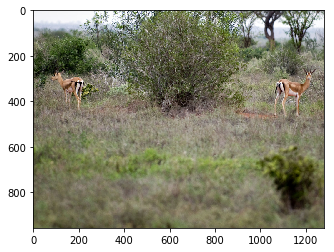

In [17]:
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from matplotlib import pyplot
from matplotlib.patches import Rectangle
%matplotlib inline

 
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = int(len(anchors)/2) # this is number of anchor boxes
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5 # Shall give you 80 classes or labels
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
 
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()
    
# load yolov3 model
model = load_model('model_2.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = '/home/scar3crow/Downloads/deer.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

 
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels. See there are 80 classes in YOLO
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
zebra 94.91060972213745
zebra 99.86329674720764
zebra 96.8708872795105


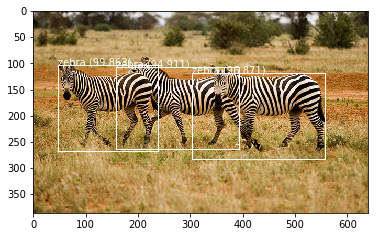

In [18]:
# load yolov3 model
model = load_model('model_2.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = '/home/scar3crow/Downloads/zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

 
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels. See there are 80 classes in YOLO
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
zebra 84.57193970680237
zebra 83.23181867599487
zebra 73.33771586418152


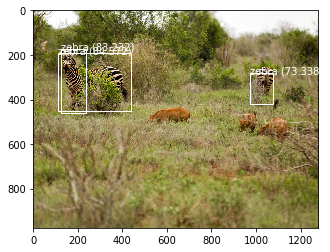

In [19]:
# load yolov3 model
model = load_model('model_2.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = '/home/scar3crow/Downloads/zebra_2.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

 
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels. See there are 80 classes in YOLO
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
grid size =  13 X 13
========================== (13, 13, 3, 85)
++++++++++++++++++++++++++ 80
shape of yhat[0][0][..., :2] =  (13, 13, 3, 2)
shape of yhat[0][0][..., 4:] =  (13, 13, 3, 81)
shape of yhat[0][0][..., 5:] =  (13, 13, 3, 80)
grid size =  26 X 26
========================== (26, 26, 3, 85)
++++++++++++++++++++++++++ 80
shape of yhat[0][0][..., :2] =  (26, 26, 3, 2)
shape of yhat[0][0][..., 4:] =  (26, 26, 3, 81)
shape of yhat[0][0][..., 5:] =  (26, 26, 3, 80)
grid size =  52 X 52
========================== (52, 52, 3, 85)
++++++++++++++++++++++++++ 80
shape of yhat[0][0][..., :2] =  (52, 52, 3, 2)
shape of yhat[0][0][..., 4:] =  (52, 52, 3, 81)
shape of yhat[0][0][..., 5:] =  (52, 52, 3, 80)
truck 79.7393798828125
truck 83.19754600524902
person 88.04333209991455
person 60.404783487319946


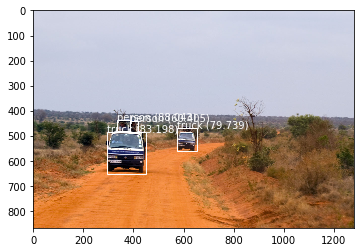

In [118]:
# load yolov3 model
model = load_model('model_2.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = '/home/scar3crow/Downloads/car_1.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

 
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels. See there are 80 classes in YOLO
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [25]:
model_new_2.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
___________________________________________________________________________________________

In [32]:
grid_h_1, grid_w_1 = yhat[0][0].shape[:2]
grid_h_2, grid_w_2 = yhat[1][0].shape[:2]
grid_h_3, grid_w_3 = yhat[2][0].shape[:2]

print('1st grid size = ', grid_w_1, 'X', grid_h_1)
print('2nd grid size = ', grid_w_2, 'X', grid_h_2)
print('3rd grid size = ', grid_w_3, 'X', grid_h_3)

yhat[0][0].shape

1st grid size =  13 X 13
2nd grid size =  26 X 26
3rd grid size =  52 X 52


(13, 13, 255)

In [34]:
yhat[0][0] = yhat[0][0].reshape((grid_h_1, grid_w_1, 3, -1))

yhat[0][0].shape

ValueError: could not broadcast input array from shape (13,13,3,85) into shape (13,13,255)

In [39]:
nb_class = yhat[0][0].shape[-1] - 5

print('Number of classes = ', nb_class)

yhat[0][0]

Number of classes =  250


array([[[ 0.5748132 ,  0.3250686 , -0.21481928, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.8537289 ,  0.5637205 ,  0.37201056, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.2622627 ,  0.76477015,  0.4005755 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.3178251 ,  0.63149595, -0.08651964, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.64943886,  0.7452805 ,  0.0681512 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.12918542,  0.7177194 ,  0.2587992 , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.78886884,  0.5872379 , -0.43003675, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.46314672,  0.7472127 , -0.03502522, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.33711946,  0.48128384,  0.00209957, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.48432636,  0.35212785, -0.2210339 , ...,  

In [38]:
len(yhat[0][0][0][0]) #all predictions of 1st grid in 19X19 grids = (5 + 80(no. of classes)) X 3(no. of anchor boxes)


255

In [46]:
print(yhat[0][0][..., :2].shape)
yhat[0][0][..., :2]

(13, 13, 2)


array([[[0.5748132 , 0.3250686 ],
        [0.8537289 , 0.5637205 ],
        [0.2622627 , 0.76477015],
        [0.50704724, 0.7181635 ],
        [0.5439768 , 0.65933365],
        [0.547533  , 0.54359776],
        [0.28668413, 0.57880616],
        [0.38450864, 0.43294442],
        [0.5697097 , 0.57499874],
        [0.3570068 , 0.5455682 ],
        [0.3178251 , 0.63149595],
        [0.64943886, 0.7452805 ],
        [0.12918542, 0.7177194 ]],

       [[0.78886884, 0.5872379 ],
        [0.46314672, 0.7472127 ],
        [0.33711946, 0.48128384],
        [0.45699972, 0.29545653],
        [0.5309766 , 0.24190083],
        [0.58537567, 0.30798882],
        [0.18846056, 0.31947112],
        [0.36514717, 0.23001683],
        [0.4811306 , 0.3678639 ],
        [0.35082027, 0.36877218],
        [0.48432636, 0.35212785],
        [0.5022241 , 0.57810336],
        [0.4117442 , 0.6502072 ]],

       [[0.42542675, 0.4086642 ],
        [0.55520535, 0.32404655],
        [0.42849675, 0.76104015],
        [0

In [47]:
_sigmoid(yhat[0][0][..., :2])

array([[[0.6398731 , 0.580559  ],
        [0.7013488 , 0.637313  ],
        [0.5651924 , 0.6823885 ],
        [0.62411404, 0.67220247],
        [0.63273704, 0.65911067],
        [0.63356304, 0.63264894],
        [0.57118416, 0.64079267],
        [0.5949601 , 0.60657656],
        [0.6386962 , 0.6399158 ],
        [0.58831567, 0.63310677],
        [0.5787941 , 0.6528286 ],
        [0.65688396, 0.67814946],
        [0.53225154, 0.6721046 ]],

       [[0.6875884 , 0.64273113],
        [0.61376035, 0.67857105],
        [0.5834906 , 0.618051  ],
        [0.6123022 , 0.5733315 ],
        [0.6297109 , 0.56018203],
        [0.64230335, 0.57639426],
        [0.54697615, 0.5791954 ],
        [0.5902859 , 0.557252  ],
        [0.6180148 , 0.59094274],
        [0.5868165 , 0.59116226],
        [0.61876893, 0.58713347],
        [0.6229819 , 0.6406309 ],
        [0.60150605, 0.65705717]],

       [[0.6047811 , 0.6007675 ],
        [0.6353424 , 0.5803101 ],
        [0.60551465, 0.68157953],
        [0

In [57]:
print('shape of yhat[0][0][..., :2] = ', yhat[0][0][..., :2].shape)
print('shape of yhat[0][:2] = ', yhat[0][0][:2].shape)
#print('shape of yhat[0][, :2] = ', yhat[0][0][, :2].shape)
print('shape of yhat[0][0][..., 4:] = ', yhat[0][0][..., 4:].shape)
print('shape of yhat[0][0][4:] = ', yhat[0][0][4:].shape)
#print('shape of yhat[0][0][, 4:] = ', yhat[0][0][, 4:].shape)
print('shape of yhat[0][0][..., 5:] = ', yhat[0][0][..., 5:].shape)
print('shape of yhat[0][0][5:] = ', yhat[0][0][5:].shape)

shape of yhat[0][0][..., :2] =  (13, 13, 2)
shape of yhat[0][:2] =  (2, 13, 255)
shape of yhat[0][0][..., 4:] =  (13, 13, 251)
shape of yhat[0][0][4:] =  (9, 13, 255)
shape of yhat[0][0][..., 5:] =  (13, 13, 250)
shape of yhat[0][0][5:] =  (8, 13, 255)


In [116]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    
    grid_h, grid_w = netout.shape[:2]
    print('grid size = ', grid_h, 'X', grid_w)
    
    nb_box = int(len(anchors)/2) # this is number of anchor boxes
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    print('==========================', netout.shape)
    nb_class = netout.shape[-1] - 5 # Shall give you 80 classes or labels
    print('++++++++++++++++++++++++++', nb_class)
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    print('shape of yhat[0][0][..., :2] = ', netout[..., :2].shape)
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    print('shape of yhat[0][0][..., 4:] = ', netout[..., 4:].shape)
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    print('shape of yhat[0][0][..., 5:] = ', netout[..., 5:].shape)
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = int(i / grid_w)
        col = (i % grid_w)
        for b in range(nb_box):
            # 5th element 0r index=4th is objectness score
            #objectness = netout[int(row)][int(col)][b][4]
            objectness = netout[row, col, b, 4]

            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            #x, y, w, h = netout[int(row)][int(col)][b][:4]
            x, y, w, h = netout[row,col,b,:4]
            
            # print('x, y, w, h = ', b, ',', x, ',', y, ',', w, ',', h)
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # print('x, y, w, h = ', b, ',', x, ',', y, ',', w, ',', h)
            
            # last elements are class probabilities
            #classes = netout[int(row)][col][b][5:]
            classes = netout[row,col,b,5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
        
    return boxes

# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
    
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    

grid size =  13 X 13
========================== (13, 13, 3, 85)
++++++++++++++++++++++++++ 80
shape of yhat[0][0][..., :2] =  (13, 13, 3, 2)
shape of yhat[0][0][..., 4:] =  (13, 13, 3, 81)
shape of yhat[0][0][..., 5:] =  (13, 13, 3, 80)
grid size =  26 X 26
========================== (26, 26, 3, 85)
++++++++++++++++++++++++++ 80
shape of yhat[0][0][..., :2] =  (26, 26, 3, 2)
shape of yhat[0][0][..., 4:] =  (26, 26, 3, 81)
shape of yhat[0][0][..., 5:] =  (26, 26, 3, 80)
grid size =  52 X 52
========================== (52, 52, 3, 85)
++++++++++++++++++++++++++ 80
shape of yhat[0][0][..., :2] =  (52, 52, 3, 2)
shape of yhat[0][0][..., 4:] =  (52, 52, 3, 81)
shape of yhat[0][0][..., 5:] =  (52, 52, 3, 80)


In [112]:
anchors[0]

[116, 90, 156, 198, 373, 326]

In [114]:
b = 0
anchors[2 * b + 0]

[116, 90, 156, 198, 373, 326]

In [74]:
i = 12
row = int(i / grid_w)
col = int(i % grid_w)
print(row, col)

0 12


In [83]:
print(type(boxes[0]))


<class '__main__.BoundBox'>


In [89]:
print(boxes[0].classes) # see there are 80 classes

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [119]:
print(boxes[0].xmin, boxes[0].ymin, boxes[0].xmax, boxes[0].ymax, boxes[0].objness, boxes[0].classes)

-87 -72 200 115 3.0576743e-08 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [120]:
print(boxes[10646].xmin, boxes[10646].ymin, boxes[10646].xmax, boxes[10646].ymax, boxes[10646].objness, boxes[10646].classes)

1148 853 1379 869 3.7936263e-07 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [102]:
print(len(boxes))

10647


In [108]:
print(image_h, image_w, input_h, input_w)

868 1280 416 416


In [109]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)


In [117]:
print(boxes[0].xmin, boxes[0].ymin, boxes[0].xmax, boxes[0].ymax, boxes[0].objness, boxes[0].classes)

-0.0617749708203169 -0.05745547694655565 0.16316666224828133 0.1588471683745201 0.659046 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3
        
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# suppress non-maximal boxes
do_nms(boxes, 0.5)


In [121]:
sorted_indices = np.argsort([-box.classes[0] for box in boxes])
sorted_indices

array([ 6790,  6795,     0, ...,  3552,  3554, 10646])

In [122]:
sorted_indices.shape

(10647,)

In [124]:
aaa = [-box.classes[0] for box in boxes]

In [127]:
boxes[0].classes[0]

0.0

In [129]:
len(anchors)//6

0

In [132]:
anchors[:6]

[[116, 90, 156, 198, 373, 326],
 [30, 61, 62, 45, 59, 119],
 [10, 13, 16, 30, 33, 23]]